In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    

In [2]:
%matplotlib notebook

# Select data set

In [3]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'

# Set responsivity params

In [8]:
responsive_test = 'nstds'
responsive_thr = 10
n_stds = 2.5


# Set bootstrap params

In [9]:
n_bootstrap_iters = 1000
n_resamples = 20
n_intervals_interp = 3

In [12]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


/n/coxfs01/julianarhee/aggregate-visual-areas


In [13]:
sdata['animalid'].unique()

array(['JC084', 'JC111', 'JC091', 'JC085', 'JC089', 'JC092', 'JC090',
       'JC099', 'JC097', 'JC110', 'JC076', 'JC078', 'JC080', 'JC083'], dtype=object)

# Colors

In [14]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

# Select data

## IGNORE THESE:
##### V1:  JC076-20190501, JC083-20190510
    - if rfs only, ignore: JC083-20190510, JC083-20190511, 
    
    - if blobs & rfs only, ignore: JC083_20190510, JC083-20190511
    
    - if ALL stimuli, ignore: JC083-20190507, JC083-20190510, 
    
#### Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if rfs only, ignore: JC078-20190504, JC078-2019513, 
                           JC083-20190512

    - if blobs & rfs: ignore: JC078-20190426, JC078-2019513
                              JC083-20190512
                              
    - if ALL stimuli, ignore: JC078-20190430, JC078-20190426, JC078-20190504
                              JC083-20190508
#### Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [15]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']

also_exclude = ['JC083-20190507', 'JC083-20190510', 
                'JC078-20190430', 'JC078-20190426', 'JC078-20190504',
                'JC083-20190508']

# also exclude: 'JC083-20190512' -- different configs
excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
excluded_sessions.append('JC083-20190512')
print(len(excluded_sessions))

16


In [16]:
dsets = sdata[sdata['experiment']=='gratings']
print dsets.shape

(25, 5)


In [17]:
dsets['visual_area'].unique()

array(['V1', 'Lm', 'Li'], dtype=object)

# Aggregate non-ori distN

In [77]:
import math

In [21]:
def get_tuning_index(g, param='sf'):
    R1 = abs(g.groupby([param])['response'].mean().values[0])
    R2 = abs(g.groupby([param])['response'].mean().values[1])

    return (R1 - R2) / (R1+R2)



In [18]:
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                 responsive_thr=responsive_thr, n_stds=n_stds, n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)
print fit_desc

outdir = os.path.join(aggregate_dir, '%s-tuning' % 'gratings', 'nonori-params')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print outdir

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/nonori-params


In [24]:
incorrect_nvalues=[]
dflist = []
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '-'.join([animalid, session])
    if skey in excluded_sessions:
        print("excluding: %s" % skey)
        continue

    exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    exp.print_info()
    roi_list, nrois_total = exp.get_responsive_cells(response_type=response_type, 
                                        responsive_test=responsive_test, 
                                        responsive_thr=responsive_thr, 
                                        n_stds=n_stds)

    print("Found %i of %i responsive cells [test: %s (thr %.2f, n_stds: %.2f)" % (len(roi_list), nrois_total, responsive_test, responsive_thr, n_stds))
    presponses = exp.get_nonori_params()

    n_sizes = len(presponses['size'].unique())
    n_speeds = len(presponses['speed'].unique()) 
    n_sfs = len(presponses['sf'].unique()) 
    if n_sizes != 2 or n_speeds != 2 or n_sfs != 2:
        incorrect_nvalues.append(skey)
        continue
        
    sf_prefs = [get_tuning_index(g, param='sf') for r, g in presponses.groupby(['cell'])]
    size_prefs = [get_tuning_index(g, param='size') for r, g in presponses.groupby(['cell'])]
    speed_prefs = [get_tuning_index(g, param='speed') for r, g in presponses.groupby(['cell'])]

    paramdf = pd.DataFrame({'sf': sf_prefs, 'size': size_prefs, 'speed': speed_prefs}, index=roi_list)
    paramdf['visual_area'] = [visual_area for _ in range(len(roi_list))]
    paramdf['animalid'] = [animalid for _ in range(len(roi_list))]
    paramdf['session'] = [session for _ in range(len(roi_list))]
    paramdf['fov'] = [fov for _ in range(len(roi_list))]

    dflist.append(paramdf)


... [JC089|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC089
Session: 20190522
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_2ec982_traces001_05ab30/data_arrays/datasets.npz')
No data loaded yet.
**************************************************
... getting responsive cells (test: nstds, thr: 10.00')
Found 19 of 151 responsive cells [test: nstds (thr 10.00, n_stds: 2.50)
... [combined_gratings_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_2ec982_traces001_05ab30/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps 

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 514, in get_responsive_cells
    assert len(stats_fpath) > 0, "No stats results found for: %s" % stats_dir
AssertionError: No stats results found for: /n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0x/combined_gratings_static/traces/traces001_c03491/summary_stats/nstds


adding NP offset...
... updating self
Found 21 of 221 responsive cells [test: nstds (thr 10.00, n_stds: 2.50)
... [combined_gratings_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0x/combined_gratings_static/traces/traces001_c03491/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Getting stimulus info for: combined_gratings_static
... [JC099|20190609|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC099
Session: 20190609
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_tr

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Getting stimulus info for: combined_gratings_static
... [JC083|20190511|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC083
Session: 20190511
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_1d60f5_traces001_36512c_traces001_d39be1_traces001_7f9d03_traces001_1bfee5/data_arrays/datasets.npz')
No data loaded yet.
**************************************************
... getting responsive cells (test: nstds, thr: 10.00')
Found 138 of 177 responsive cells [test: nstds (thr 10.00, n_stds: 2.50)
... [combined_gratings_static] Loading roi stats a

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 514, in get_responsive_cells
    assert len(stats_fpath) > 0, "No stats results found for: %s" % stats_dir
AssertionError: No stats results found for: /n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_c78c61_traces001_81bb92_traces001_a1405a_traces001_5c3be4/summary_stats/nstds


*** Excluding: []
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/gratings_run1
N tsecs: 4610
There are 320 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3560
... N unique frames: 3560
... Last frame to align: 4573 (N frames total, 4610)
... N tstamps: 4610
N frames per trial: 89
N tstamps: 3560
N trials in block: 40
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -255.49825784
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -661.987734573
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -656.559265137
STIM TYPE: gratings
**** File 2 of 32 *****
*** Excluding: []
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/gratings_run1
N tsecs: 4610
There are 320 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3560
... N unique frames: 3560
... Last frame to align: 4572 (N frames

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -262.692789969
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -518.187936259
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -525.500402706
STIM TYPE: gratings
**** File 13 of 32 *****
*** Excluding: []
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/gratings_run2
N tsecs: 4610
There are 320 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3560
... N unique frames: 3560
... Last frame to align: 4571 (N frames total, 4610)
... N tstamps: 4610
N frames per trial: 89
N tstamps: 3560
N trials in block: 40
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -233.602230483
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -465.579104586
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -505.059960938
STIM

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -681.428253174
STIM TYPE: gratings
**** File 24 of 32 *****
*** Excluding: []
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/gratings_run3
N tsecs: 4610
There are 320 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3560
... N unique frames: 3560
... Last frame to align: 4571 (N frames total, 4610)
... N tstamps: 4610
N frames per trial: 89
N tstamps: 3560
N trials in block: 40
('Excluding:', [u'stimulus', u'type', u'phase'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -217.940625
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -625.561151961
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -528.438419118
STIM TYPE: gratings
**** File 25 of 32 *****
*** Excluding: []
/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/gratings_run4
N tsecs: 4610
There are 320 total trials across all .tif fil

In [272]:
speed_prefs = [get_tuning_index(g, param='speed') for r, g in presponses.groupby(['cell'])]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [25]:
df = pd.concat(dflist, axis=0)
df.head()

df['cell']=df.index.tolist()

In [26]:
df.head()

sf      size     speed visual_area animalid   session  \
35  0.211945  0.334651  0.012654          Li    JC090  20190605   
36  0.118092  0.271514  0.086012          Li    JC090  20190605   
41  0.503463  0.452111  0.126047          Li    JC090  20190605   
54  0.011218  0.222215  0.099852          Li    JC090  20190605   
65 -0.210742  0.285362  0.160538          Li    JC090  20190605   

              fov  cell  
35  FOV1_zoom2p0x    35  
36  FOV1_zoom2p0x    36  
41  FOV1_zoom2p0x    41  
54  FOV1_zoom2p0x    54  
65  FOV1_zoom2p0x    65

In [29]:
len(df['animalid'].unique())

9

In [27]:
df['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

<IPython.core.display.Javascript object>


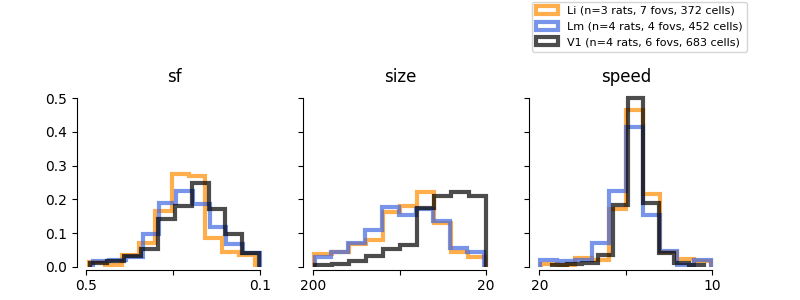

('sf', 0.1, 0.5)
('size', 20, 200)
('speed', 10, 20)
('sf', 0.1, 0.5)
('size', 20, 200)
('speed', 10, 20)
('sf', 0.1, 0.5)
('size', 20, 200)
('speed', 10, 20)


In [33]:
cdf=False
fig, axes = pl.subplots(1,3, figsize=(8, 3), sharex=False, sharey=True)
for visual_area, paramdf in df.groupby(['visual_area']):
    

#     sf_prefs = [get_tuning_index(g, param='sf') for r, g in allresponses.groupby(['cell'])]
#     size_prefs = [get_tuning_index(g, param='size') for r, g in allresponses.groupby(['cell'])]
#     speed_prefs = [get_tuning_index(g, param='speed') for r, g in allresponses.groupby(['cell'])]

#     paramdf = pd.DataFrame({'sf': sf_prefs, 'size': size_prefs, 'speed': speed_prefs}, index=range(len(sf_prefs)))

    for ax, param in zip(axes, paramdf.columns):
        nrats = len(paramdf['animalid'].unique())
        nfovs = len(list(set(['-'.join([a, s, v]) for a, s, v in paramdf[['animalid', 'session', 'fov']].values])))
        ncells_total = paramdf.shape[0]
        values = paramdf[param].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=0.7, lw=3,
                normed=0, weights=weights)
        ax.set_title(param)
        ax.set_xticks([-1, 0, 1])
        minv = sdf[param].unique().min()
        maxv = sdf[param].unique().max()
        ax.set_xticklabels([maxv, '', minv])
        print(param, minv, maxv)
#if show_legend:
ax.legend(bbox_to_anchor=(0.0, 1.5), loc=2, borderaxespad=0., fontsize=8)
sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.2, top=0.7, left=0.1, right=0.9)

pl.savefig(os.path.join(outdir, 'distn_nonori_params2.svg'))

In [299]:
sdf['sf'].unique()

array([0.1, 0.5], dtype=object)

In [304]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

# Create experiment object

In [31]:
exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
exp.print_info()

... [JC110|20191006|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
************* Experiment Object info *************
Name: combined_gratings_static
Experiment type: gratings
Animalid: JC110
Session: 20191006
FOV: FOV1_zoom2p0x
roi-id, trace-id: rois001, traces001
('Data source:', '/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_c78c61_traces001_81bb92_traces001_a1405a_traces001_5c3be4/data_arrays/datasets.npz')
No data loaded yet.
**************************************************


In [32]:
df_traces, labels, gdf, sdf = osi.load_gratings_data(exp.source, add_offset=True)


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/bootstrap_fit_tuning_curves.py:1058: RuntimeWarning: invalid value encountered in divide
  F0 = np.nanmean(dset['corrected'][:] / dset['dff'][:] )


offset: 768.01


In [8]:
roi_list, nrois_total = exp.get_responsive_cells(response_type=response_type, 
                                    responsive_test=responsive_test, 
                                    responsive_thr=responsive_thr, 
                                    n_stds=n_stds)

print("Found %i of %i responsive cells [test: %s (thr %.2f, n_stds: %.2f)" % (len(roi_list), nrois_total, responsive_test, responsive_thr, n_stds))


... getting responsive cells (test: nstds, thr: 10.00')
Found 127 of 260 responsive cells [test: nstds (thr 10.00, n_stds: 2.50)


<IPython.core.display.Javascript object>


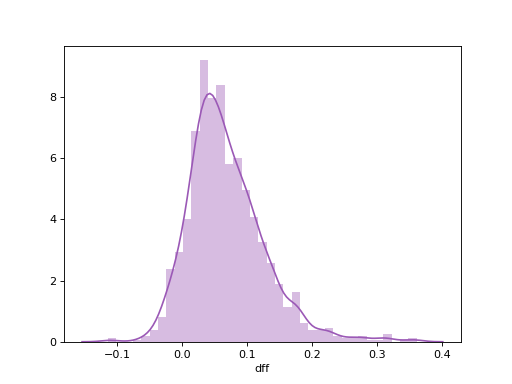

In [9]:
roi = 17
pl.figure()

sns.distplot(gdf.get_group(17)['dff'])

In [10]:
gdf.get_group(roi)['dff'].min(), gdf.get_group(17).max()

(-0.11463945452151386, bas_mean_df     4.15703e-16
 bas_std_df         0.131973
 base_mean           950.105
 base_std            105.537
 config            config064
 df                  272.622
 dff                0.361472
 snr                 1.36147
 stim_mean           1169.16
 stim_mean_df       0.361472
 trial            trial01240
 zscore              4.81535
 dtype: object)

In [25]:
presponses = exp.get_nonori_params()

... [combined_gratings_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Getting stimulus info for: combined_gratings_static


In [27]:
presponses.groupby('sf').mean()

response   size  speed        cell
sf                                     
0.1  0.086952  110.0   15.0  129.070866
0.5  0.047513  110.0   15.0  129.070866

In [33]:
[g.groupby(['sf']).mean() for r, g in presponses.groupby(['cell'])]

[     response   size  speed  cell
 sf                               
 0.1 -0.052418  110.0   15.0     0
 0.5 -0.011833  110.0   15.0     0,      response   size  speed  cell
 sf                               
 0.1  0.022319  110.0   15.0     5
 0.5  0.056293  110.0   15.0     5,      response   size  speed  cell
 sf                               
 0.1  0.063199  110.0   15.0     9
 0.5  0.026086  110.0   15.0     9,      response   size  speed  cell
 sf                               
 0.1  0.041540  110.0   15.0    10
 0.5  0.022176  110.0   15.0    10,      response   size  speed  cell
 sf                               
 0.1  0.217805  110.0   15.0    11
 0.5  0.109497  110.0   15.0    11,      response   size  speed  cell
 sf                               
 0.1  0.109825  110.0   15.0    12
 0.5  0.021636  110.0   15.0    12,      response   size  speed  cell
 sf                               
 0.1  0.150715  110.0   15.0    14
 0.5  0.089036  110.0   15.0    14,      response   siz

In [34]:
g.groupby(['sf']).mean()

response   size  speed  cell
sf                               
0.1  0.118557  110.0   15.0   258
0.5  0.052813  110.0   15.0   258

In [98]:
sf_prefs = [get_tuning_index(g, param='sf') for r, g in presponses.groupby(['cell'])]
size_prefs = [get_tuning_index(g, param='size') for r, g in presponses.groupby(['cell'])]
speed_prefs = [get_tuning_index(g, param='speed') for r, g in presponses.groupby(['cell'])]

paramdf = pd.DataFrame({'sf': sf_prefs, 'size': size_prefs, 'speed': speed_prefs}, index=roi_list)

In [105]:
g.groupby(['sf'])['response'].mean()

sf
0.1    0.118557
0.5    0.052813
Name: response, dtype: float64

In [106]:
g.groupby(['size'])['response'].mean()

size
20.0     0.095453
200.0    0.075916
Name: response, dtype: float64

In [107]:
g.groupby(['speed'])['response'].mean()

speed
10.0    0.095472
20.0    0.075897
Name: response, dtype: float64

<IPython.core.display.Javascript object>


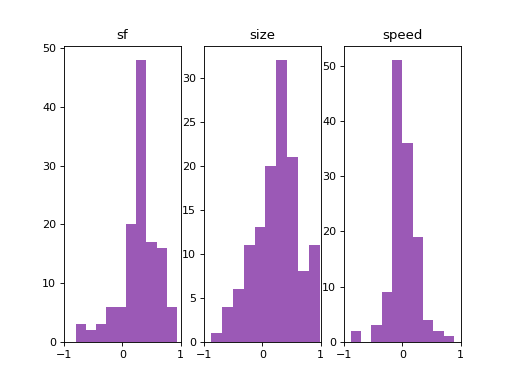

In [102]:
fig, axes = pl.subplots(1,3)
for ax, param in zip(axes, paramdf.columns):
    ax.hist(paramdf[param])
    ax.set_xlim([-1, 1])
    ax.set_title(param)
    

In [48]:
g.groupby(['size'])['response'].mean()

size
20.0     0.095453
200.0    0.075916
Name: response, dtype: float64

In [219]:
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                 responsive_thr=responsive_thr, n_stds=n_stds, n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)

sub_desc = 'nonori-params_%s' % fit_desc
print fit_desc

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [222]:
tuning_basedir = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % exp.name,
                       'traces', '%s*' % traceid, 'tuning'))[0]
tuning_basedir

outdir = os.path.join(tuning_basedir, sub_desc)
roi_fitdir = os.path.join(outdir, 'roi-boot-dists')
if not os.path.exists(roi_fitdir):
    os.makedirs(roi_fitdir)

#### Bootstrap

In [ ]:
import itertools


In [226]:
bootdf.loc[currcfgs]

0         1         2         3         4         5    \
config008  0.003591  0.002616  0.006035 -0.002457  0.008315  0.016874   
config016  0.019905  0.009595  0.014482  0.017121  0.017660  0.009516   
config024  0.042844  0.037224  0.036701  0.039861  0.028599  0.020579   
config032  0.018025  0.016688  0.021224  0.017982  0.014931  0.012822   
config040  0.026476  0.031489  0.032144  0.034180  0.019308  0.020051   
config048  0.033270  0.036149  0.034628  0.039853  0.046455  0.028703   
config056  0.008254  0.007828  0.010773  0.005764  0.015213  0.001908   
config064  0.017946  0.012683  0.016789  0.011782  0.009276  0.005356   

                6         7         8         9      ...          990  \
config008  0.020287  0.007153  0.002821  0.017109    ...     0.009152   
config016  0.013024  0.019933  0.011360  0.020909    ...     0.013907   
config024  0.047838  0.045602  0.024086  0.031756    ...     0.028763   
config032  0.023664  0.018730  0.013857  0.005414    ...     0.018729   
config040  0.031882  0.035632  0.028994  0.028757    ...     0.027372   
config048  0.036076  0.027075  0.027821  0.043386    ...     0.031565   
config056  0.011024  0.007476  0.004282  0.020001    ...     0.005244   
config064  0.012924  0.017650  0.011877  0.016344    ...     0.010503   

                991       992       993       994       995       996  \
config008  0.009497  0.007693  0.015893  0.008899  0.003986  0.017106   
config016  0.016685  0.012772  0.010921  0.018733  0.019938  0.012004   
config024  0.027028  0.024168  0.023239  0.040489  0.018343  0.042766   
config032  0.021863  0.013080  0.017786  0.014991  0.017678  0.016288   
config040  0.027405  0.025728  0.016801  0.028583  0.026026  0.035486   
config048  0.038030  0.036762  0.033781  0.038939  0.036965  0.027689   
config056  0.010428  0.008377  0.005827  0.011506  0.009530  0.008154   
config064  0.007720  0.012985  0.008497  0.016225  0.012093  0.017016   

                997       998       999  
config008  0.000732  0.006935  0.008073  
config016  0.021668  0.002447  0.020871  
config024  0.033366  0.026922  0.025713  
config032  0.015572  0.023711  0.013417  
config040  0.036586  0.028996  0.019859  
config048  0.030281  0.027678  0.037635  
config056  0.009727 -0.001457  0.010725  
config064  0.014892  0.004503  0.012621  

[8 rows x 1000 columns]

In [179]:
paramvals

(20, 20, 0.5)

<IPython.core.display.Javascript object>


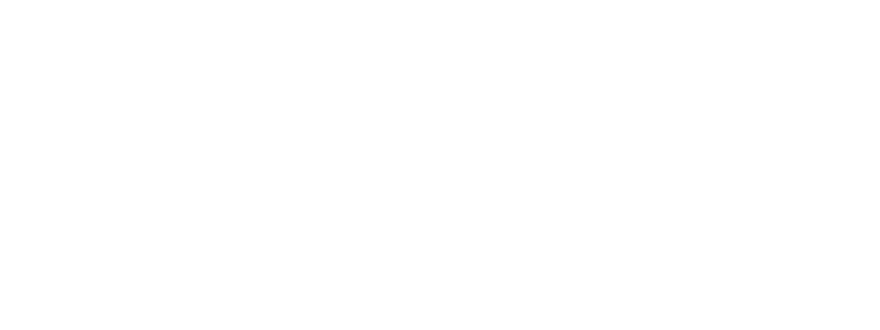

<IPython.core.display.Javascript object>


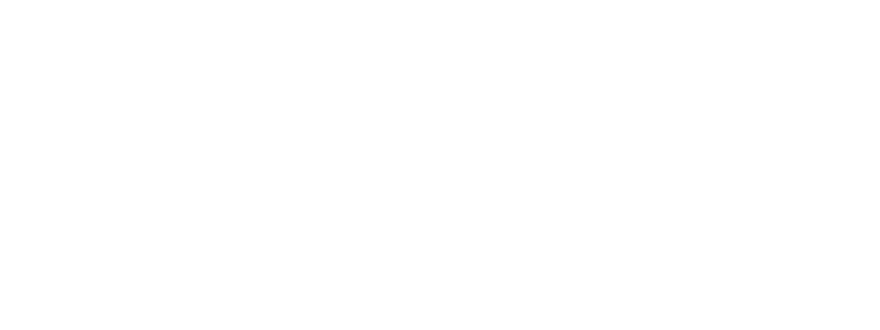

<IPython.core.display.Javascript object>


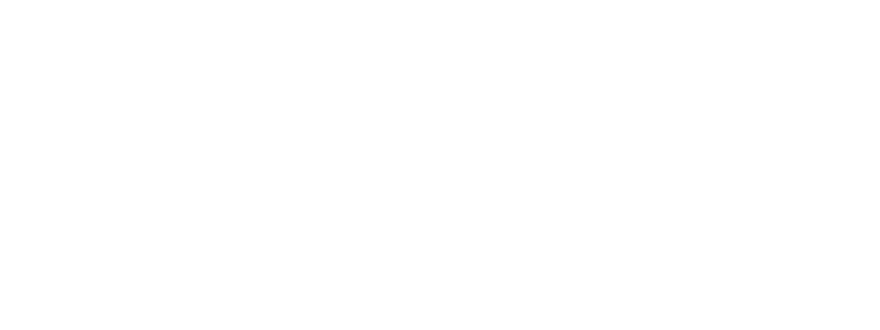

<IPython.core.display.Javascript object>


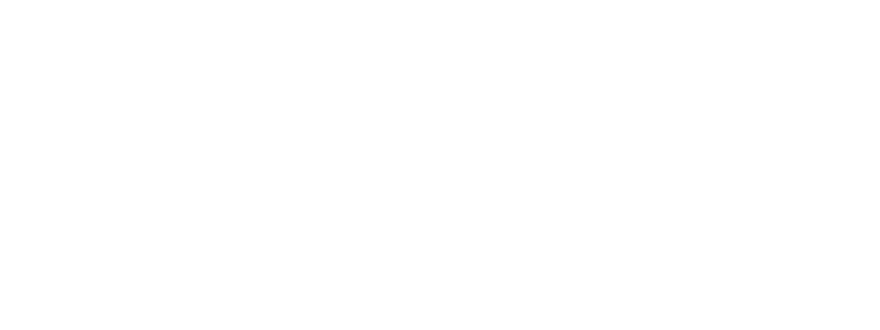

<IPython.core.display.Javascript object>


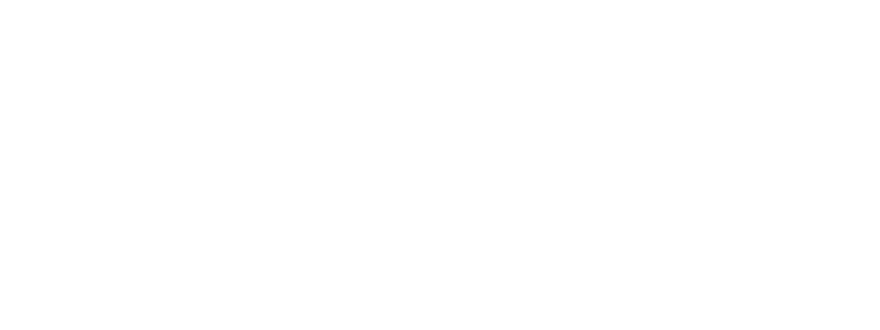

<IPython.core.display.Javascript object>


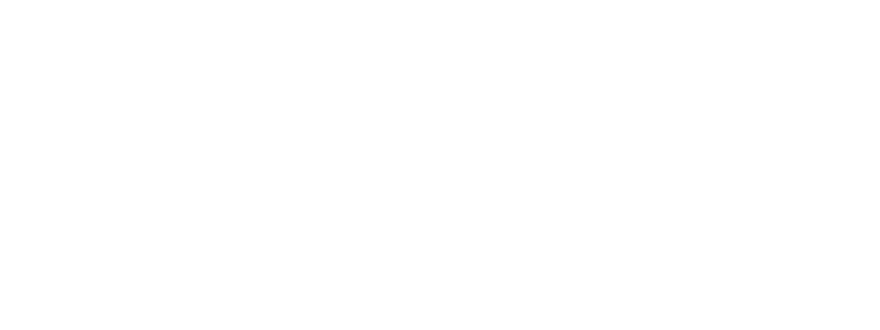

<IPython.core.display.Javascript object>


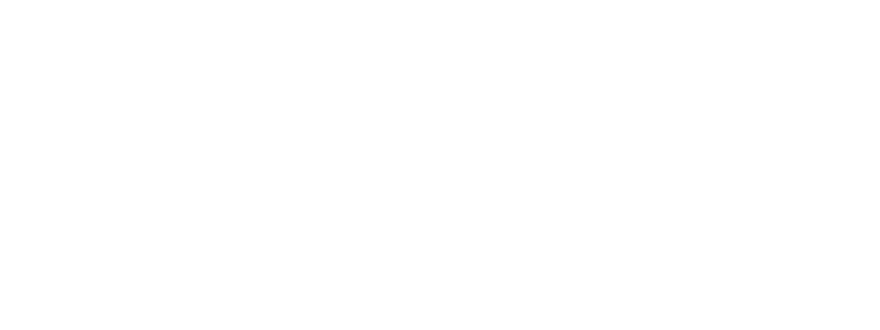

<IPython.core.display.Javascript object>


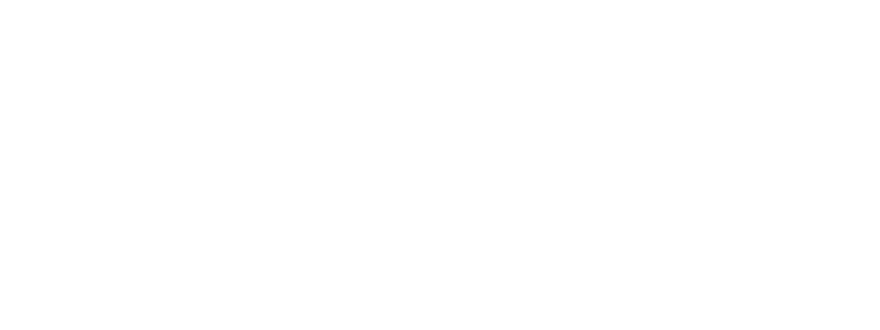

<IPython.core.display.Javascript object>


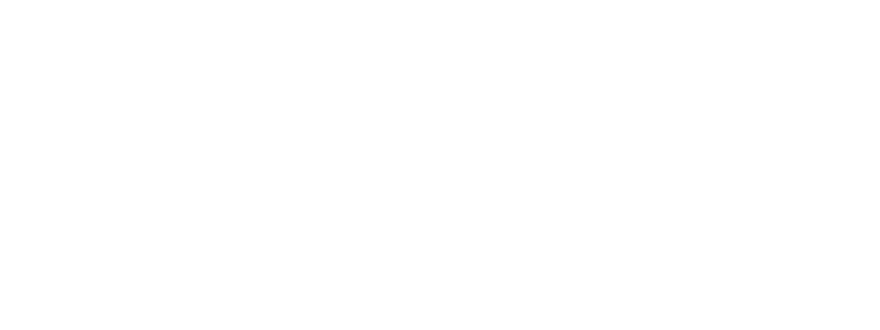

<IPython.core.display.Javascript object>


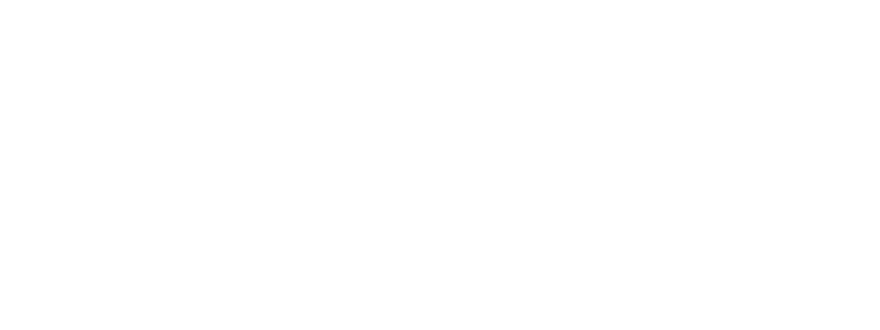

<IPython.core.display.Javascript object>


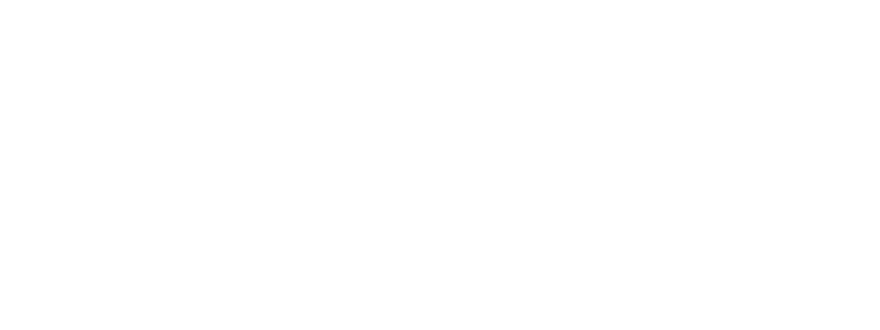

<IPython.core.display.Javascript object>


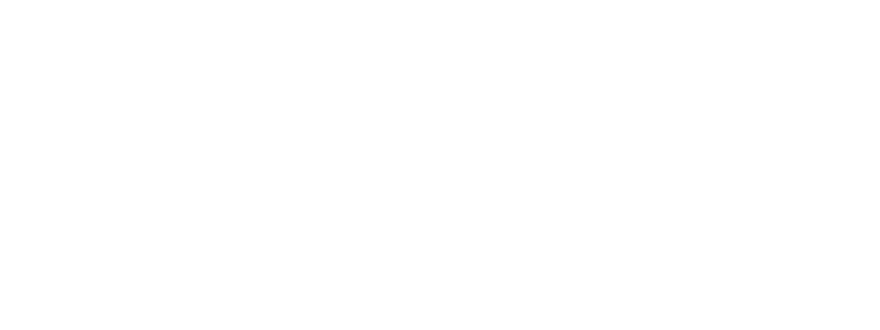

<IPython.core.display.Javascript object>


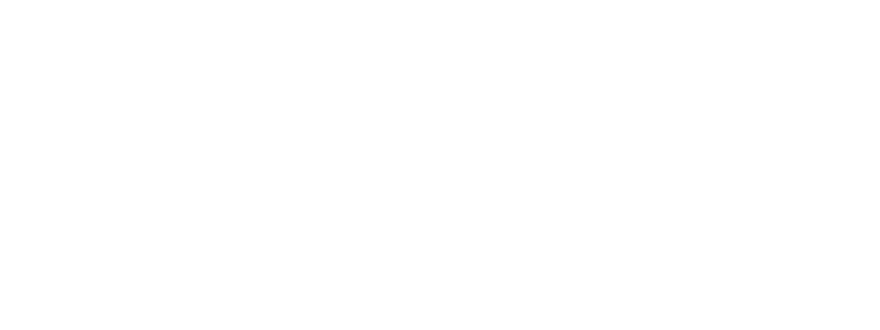

<IPython.core.display.Javascript object>


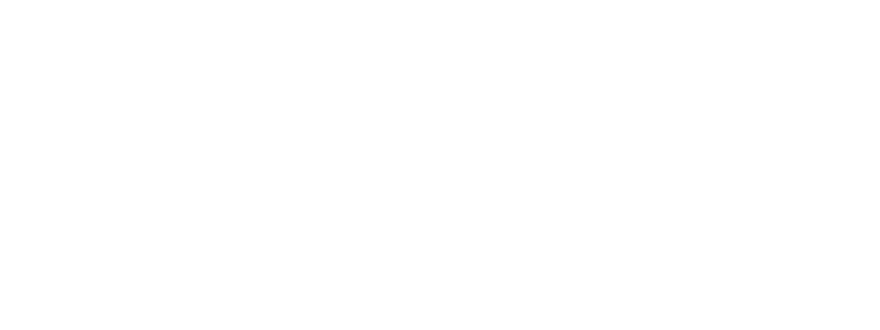

<IPython.core.display.Javascript object>


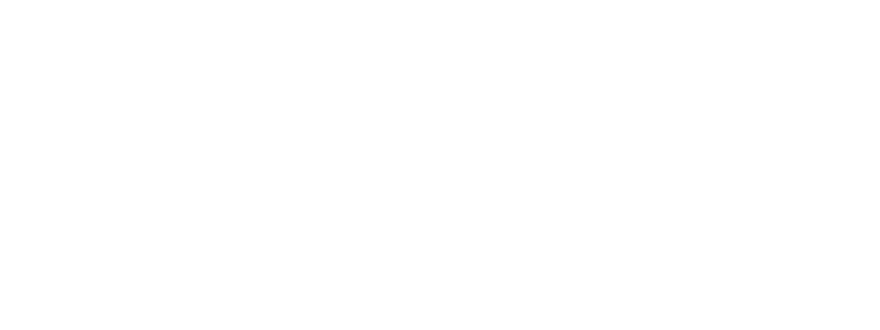

<IPython.core.display.Javascript object>


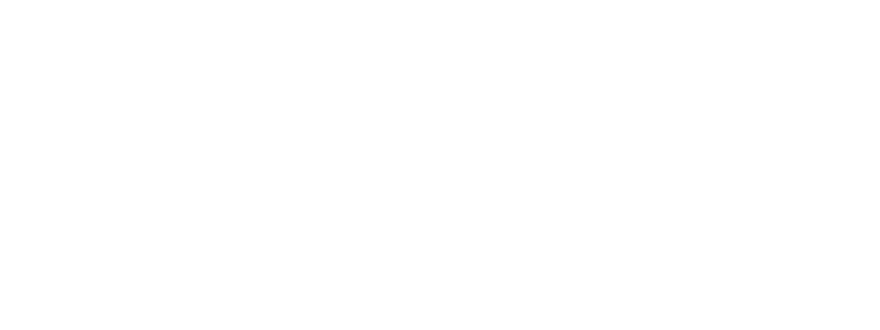

<IPython.core.display.Javascript object>


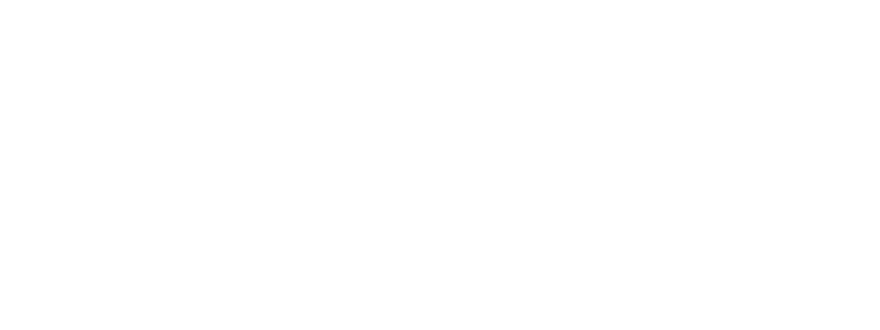

<IPython.core.display.Javascript object>


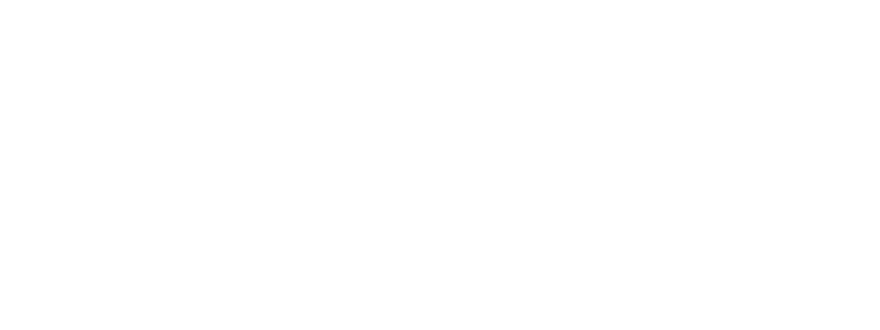

<IPython.core.display.Javascript object>


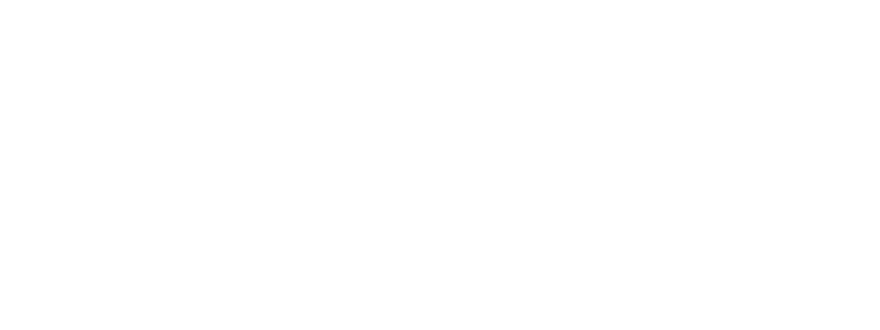

<IPython.core.display.Javascript object>


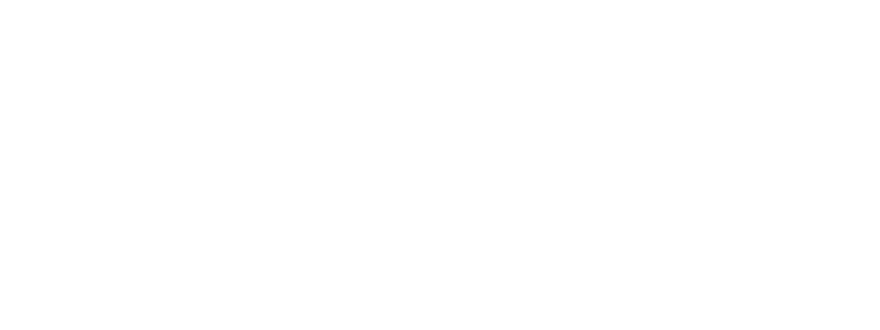

<IPython.core.display.Javascript object>


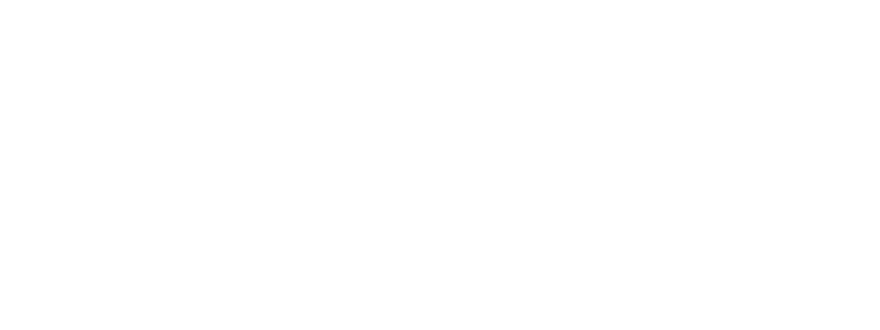

<IPython.core.display.Javascript object>


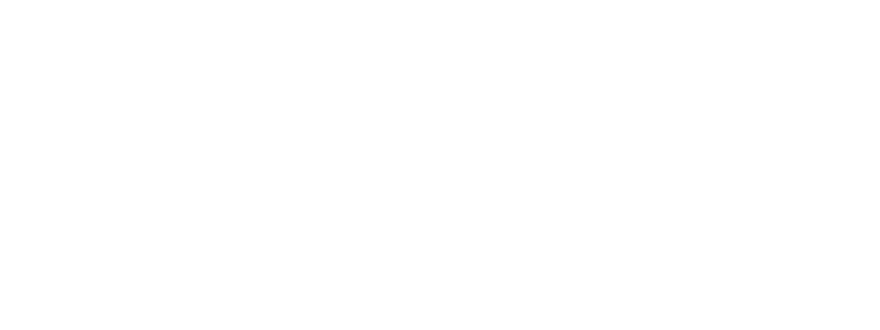

<IPython.core.display.Javascript object>


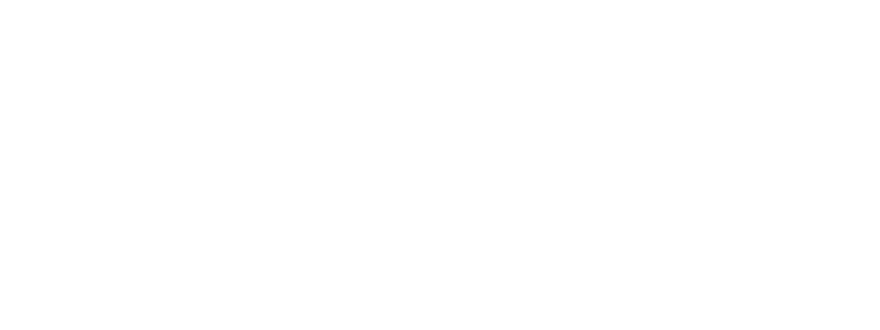

<IPython.core.display.Javascript object>


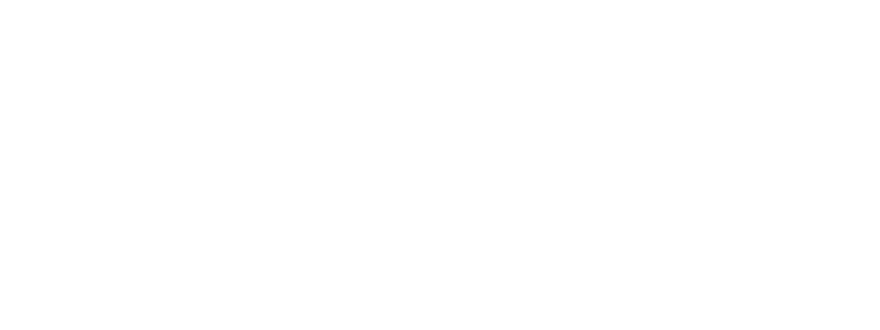

<IPython.core.display.Javascript object>


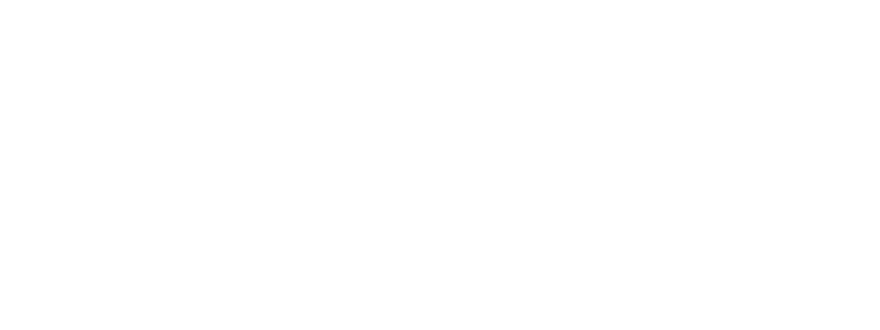

<IPython.core.display.Javascript object>


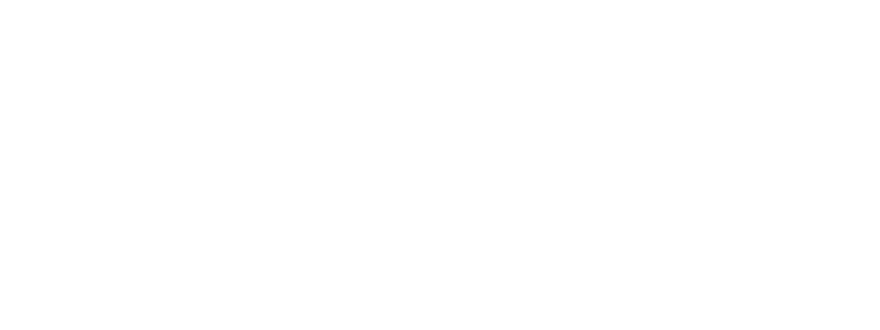

<IPython.core.display.Javascript object>


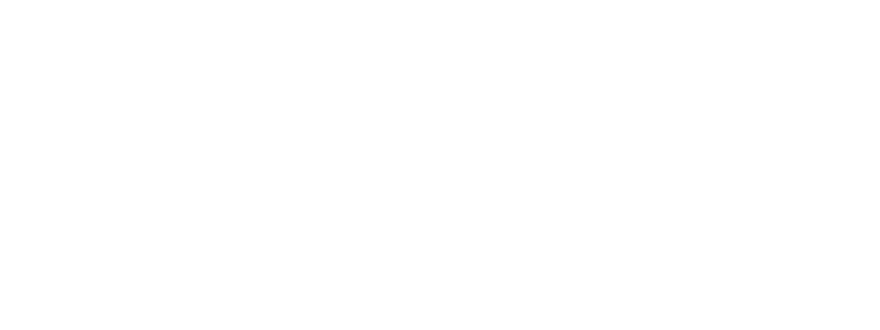

<IPython.core.display.Javascript object>


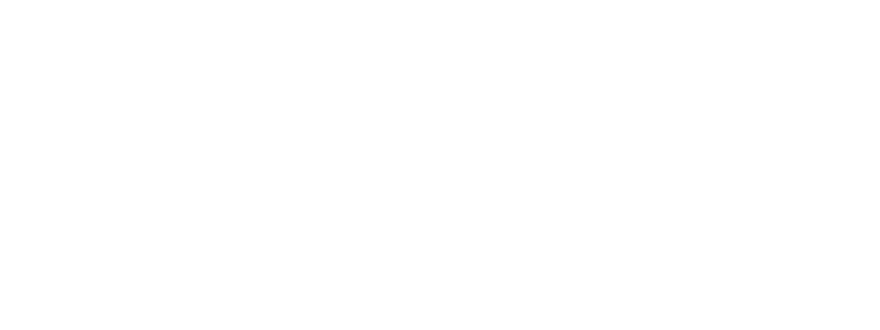

<IPython.core.display.Javascript object>


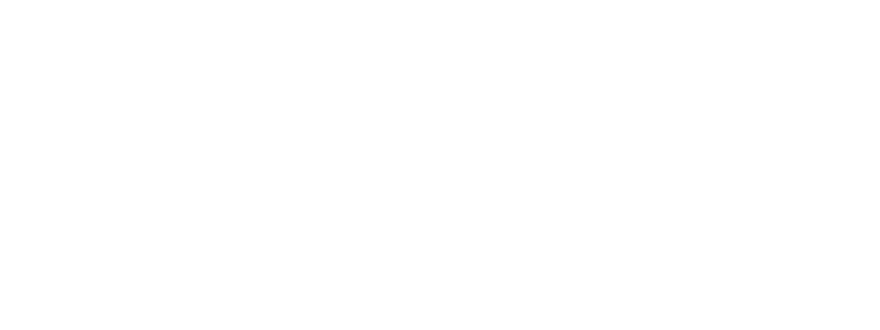

<IPython.core.display.Javascript object>


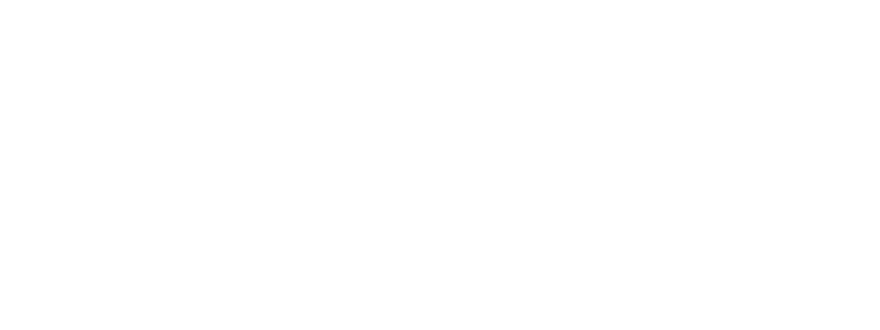

<IPython.core.display.Javascript object>


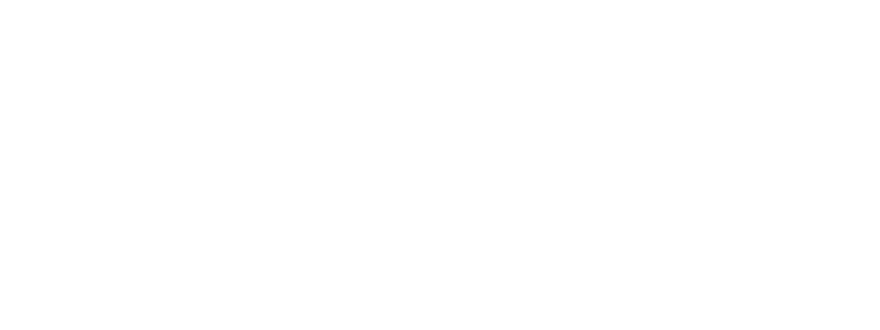

<IPython.core.display.Javascript object>


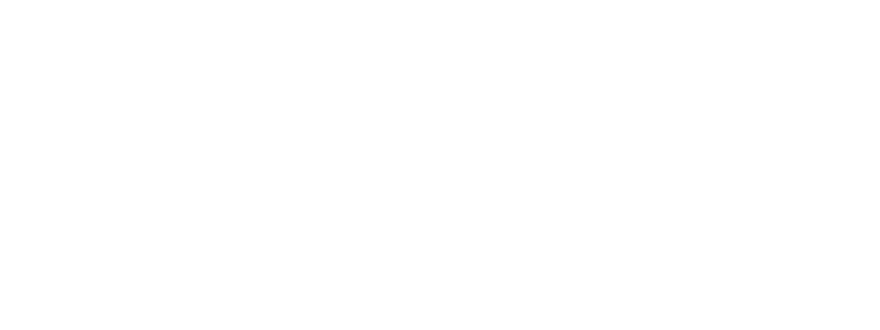

<IPython.core.display.Javascript object>


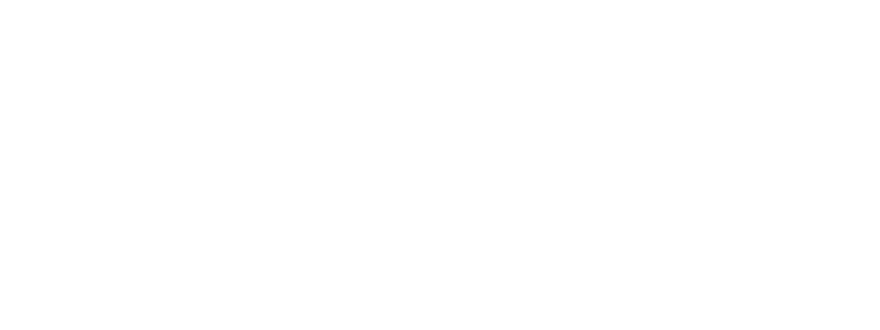

<IPython.core.display.Javascript object>


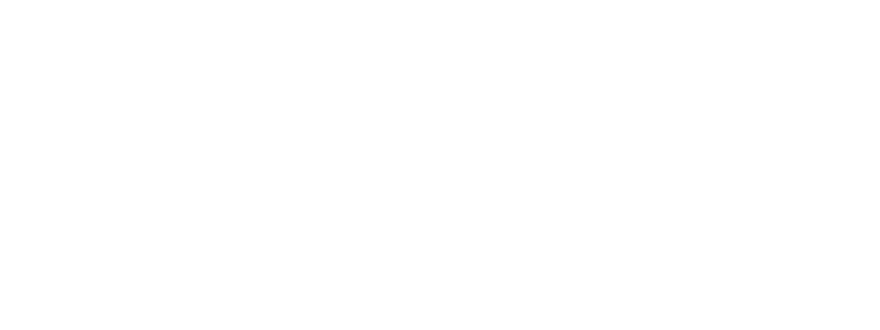

<IPython.core.display.Javascript object>


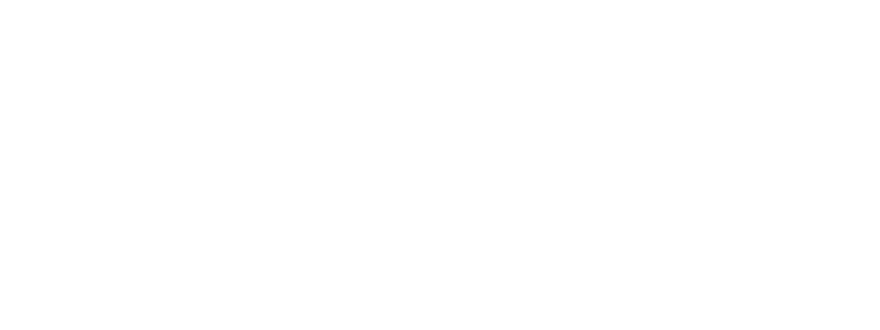

<IPython.core.display.Javascript object>


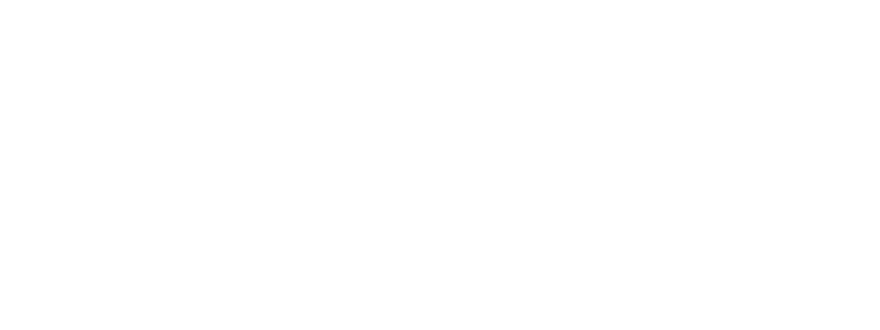

<IPython.core.display.Javascript object>


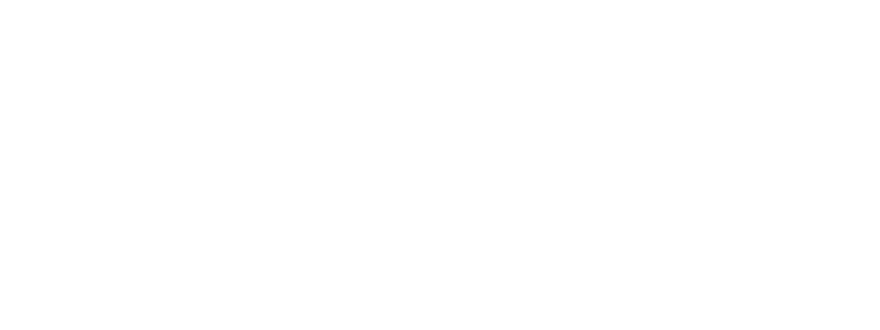

<IPython.core.display.Javascript object>


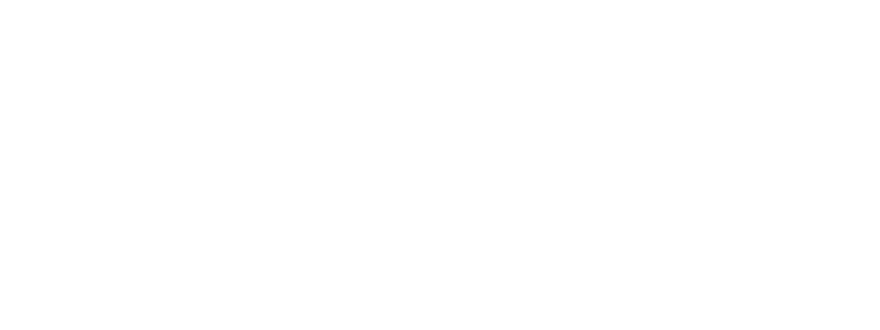

<IPython.core.display.Javascript object>


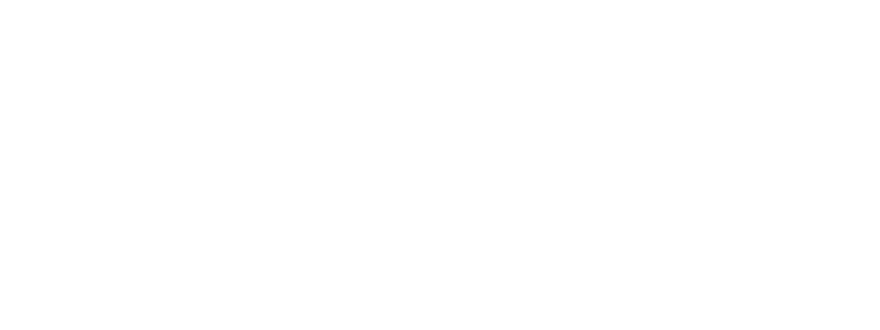

<IPython.core.display.Javascript object>


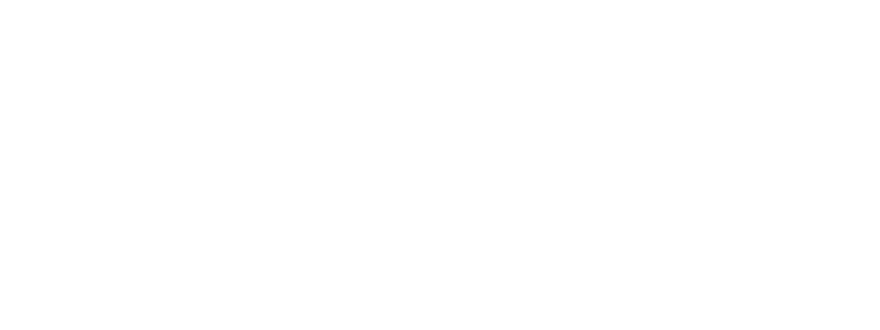

<IPython.core.display.Javascript object>


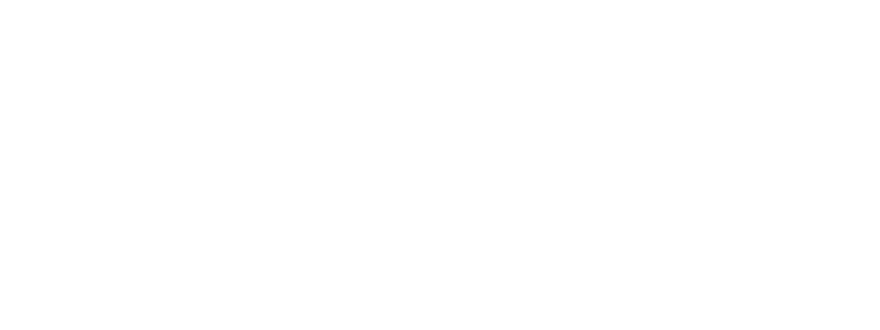

<IPython.core.display.Javascript object>


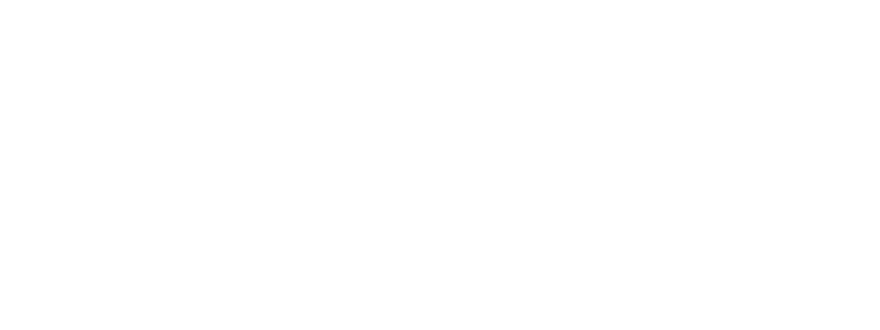

<IPython.core.display.Javascript object>


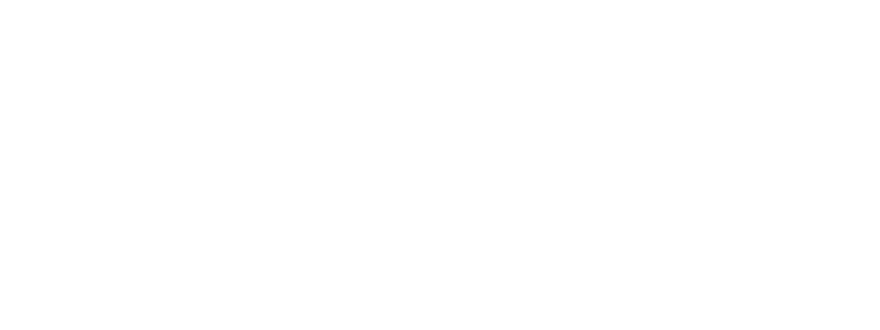

<IPython.core.display.Javascript object>


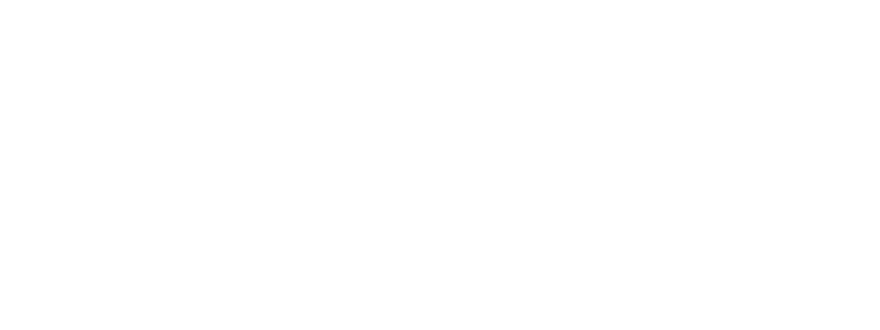

<IPython.core.display.Javascript object>


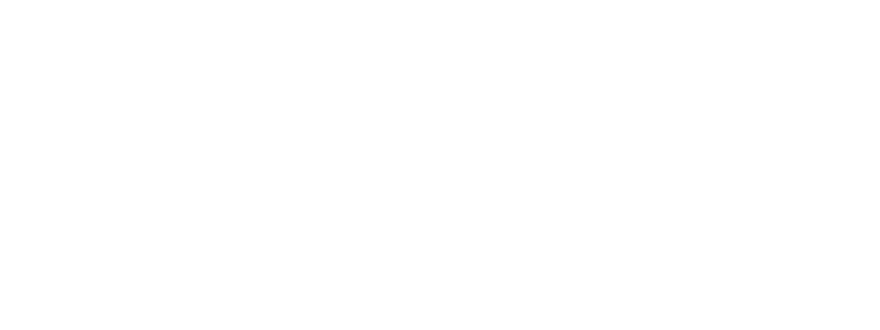

<IPython.core.display.Javascript object>


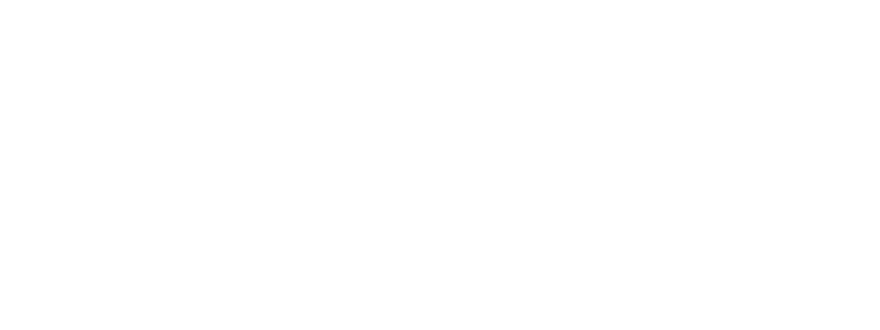

<IPython.core.display.Javascript object>


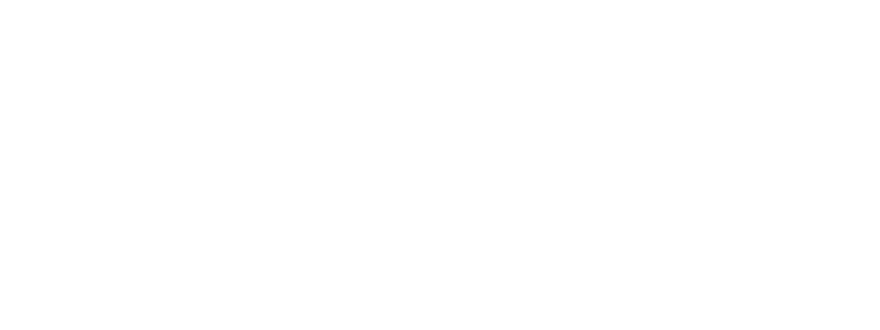

<IPython.core.display.Javascript object>


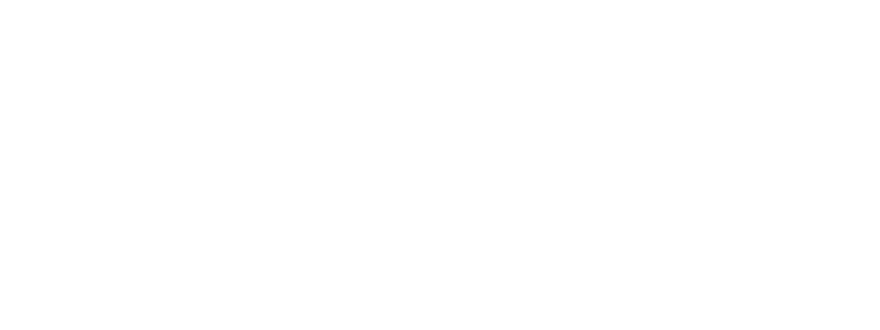

<IPython.core.display.Javascript object>


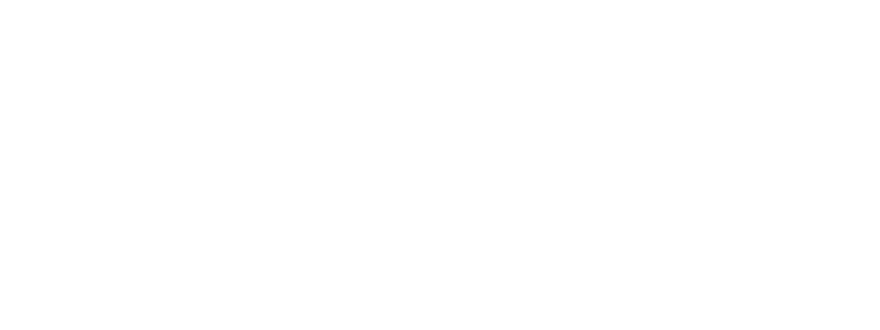

<IPython.core.display.Javascript object>


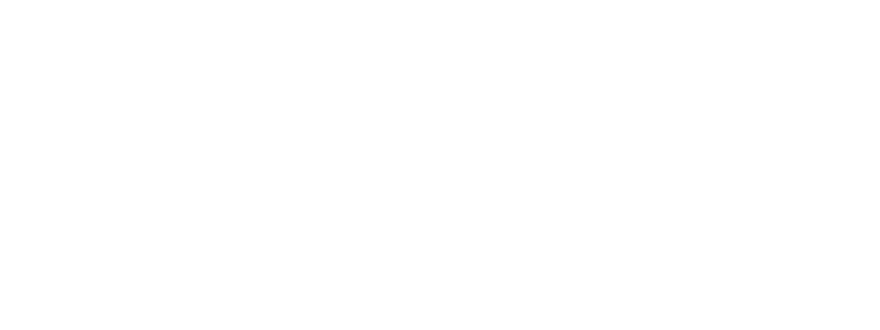

<IPython.core.display.Javascript object>


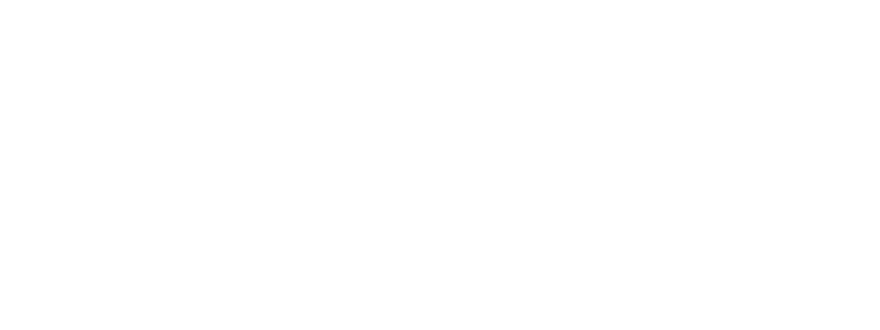

<IPython.core.display.Javascript object>


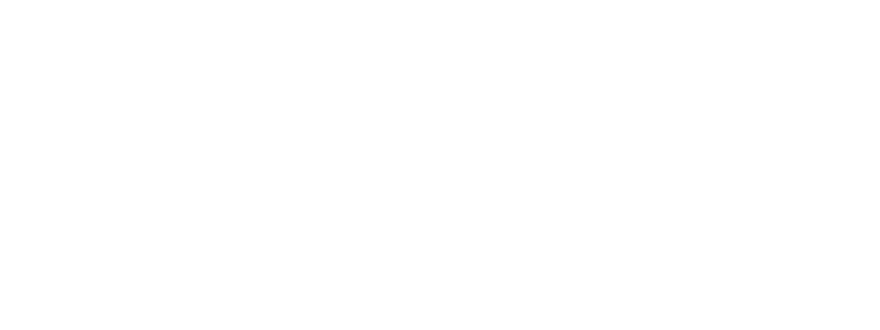

<IPython.core.display.Javascript object>


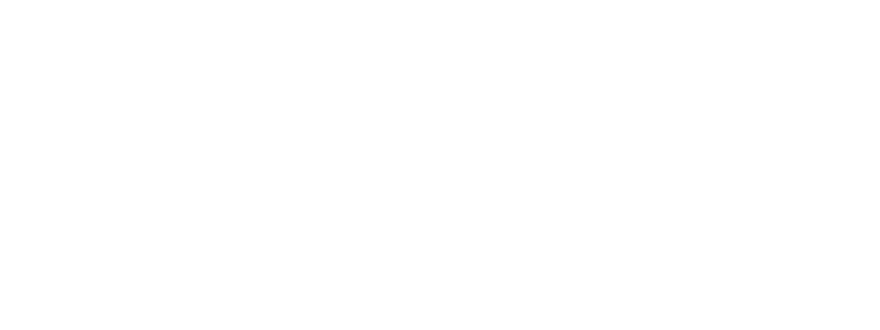

<IPython.core.display.Javascript object>


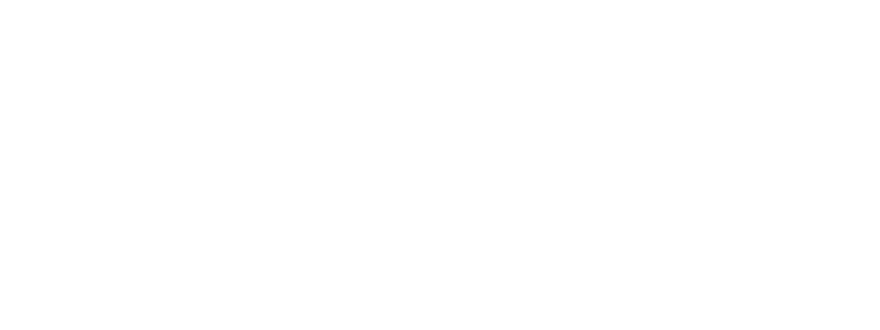

<IPython.core.display.Javascript object>


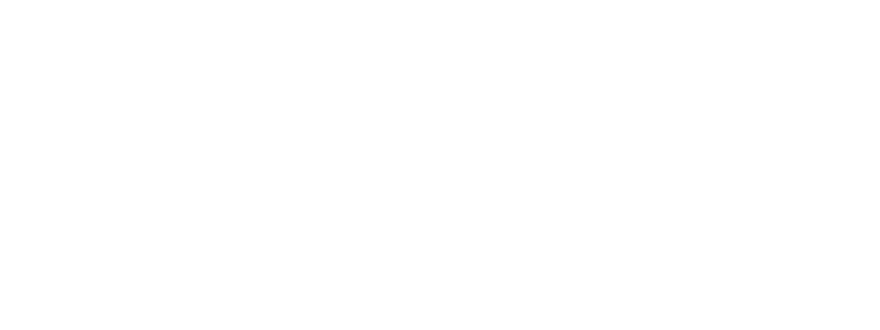

<IPython.core.display.Javascript object>


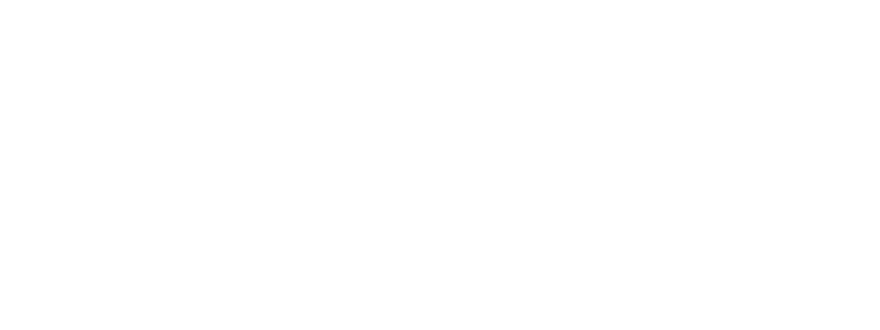

<IPython.core.display.Javascript object>


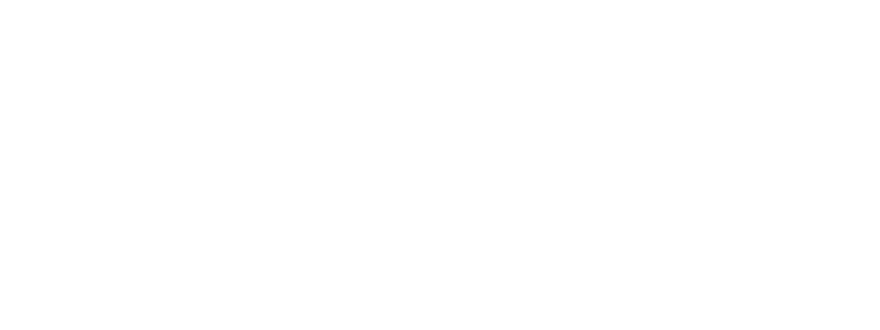

<IPython.core.display.Javascript object>


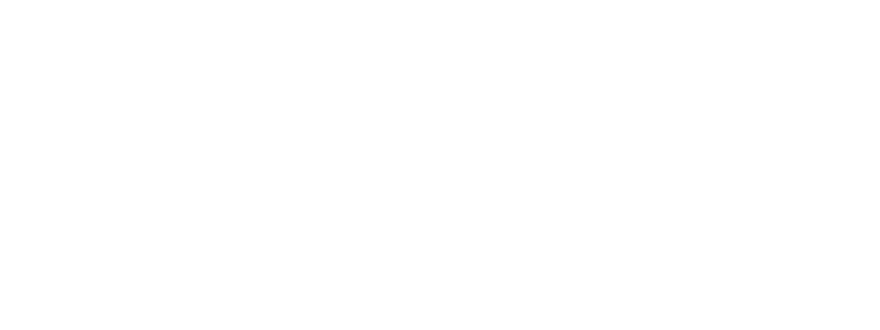

<IPython.core.display.Javascript object>


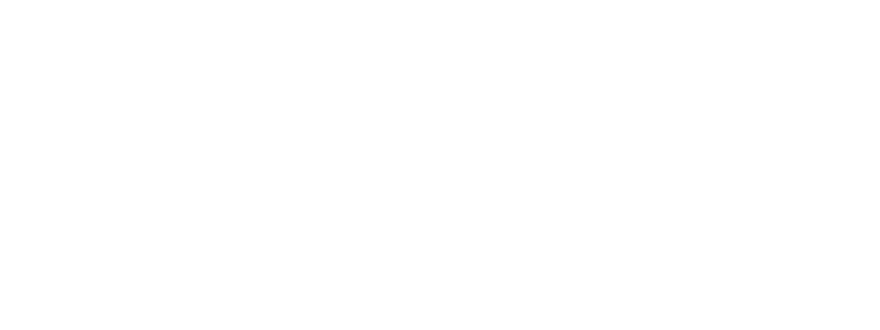

<IPython.core.display.Javascript object>


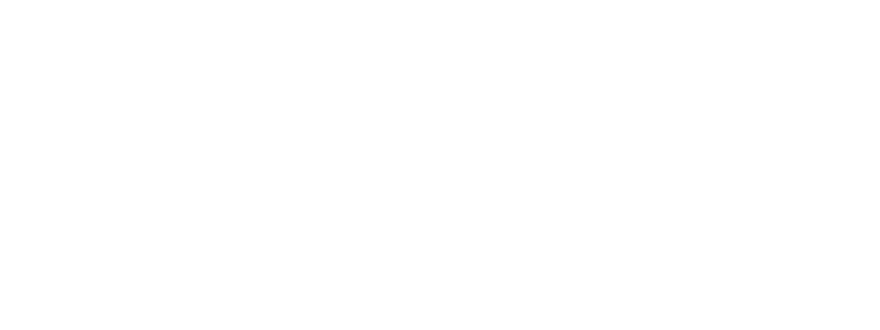

<IPython.core.display.Javascript object>


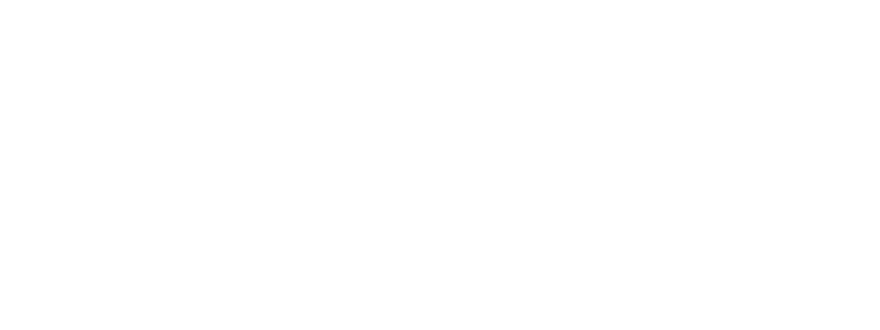

<IPython.core.display.Javascript object>


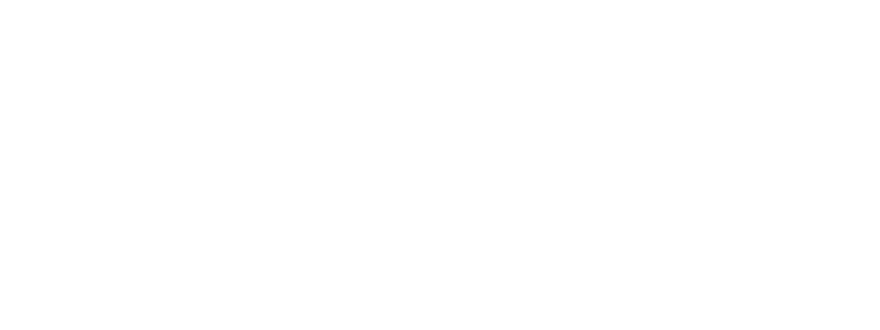

<IPython.core.display.Javascript object>


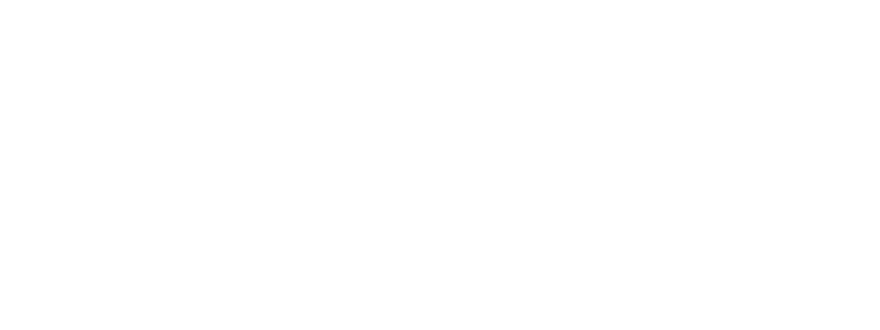

<IPython.core.display.Javascript object>


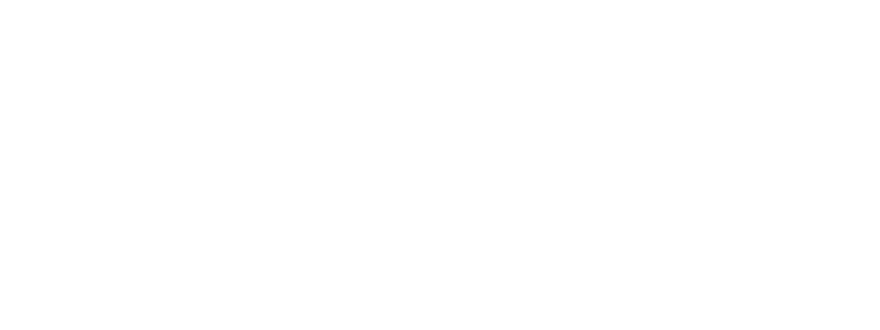

<IPython.core.display.Javascript object>


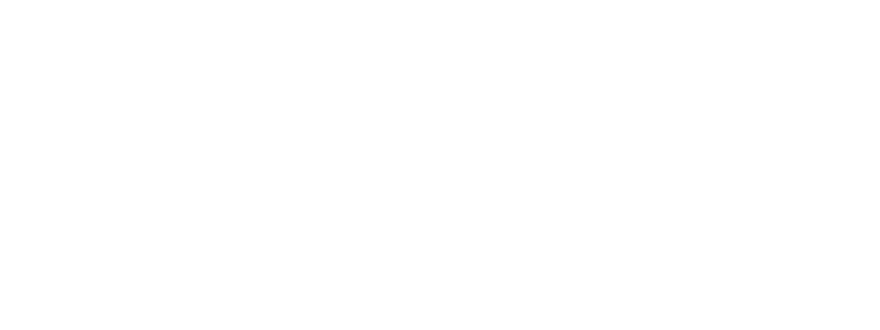

<IPython.core.display.Javascript object>


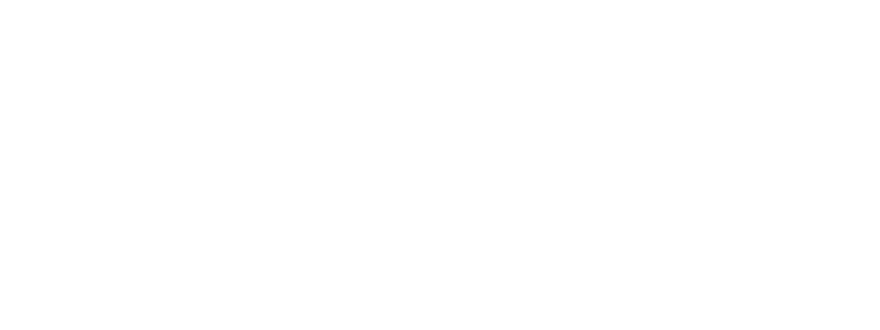

<IPython.core.display.Javascript object>


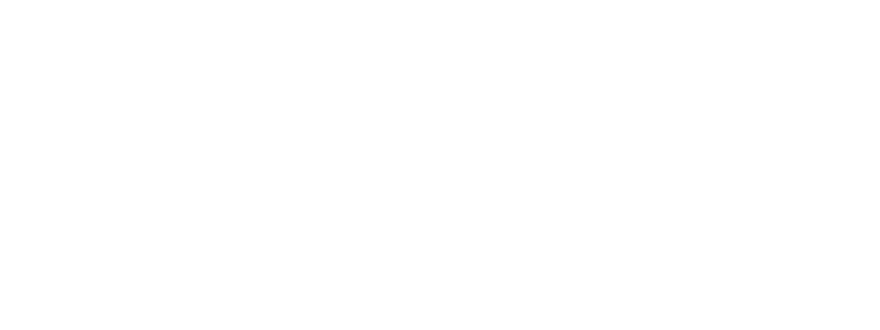

<IPython.core.display.Javascript object>


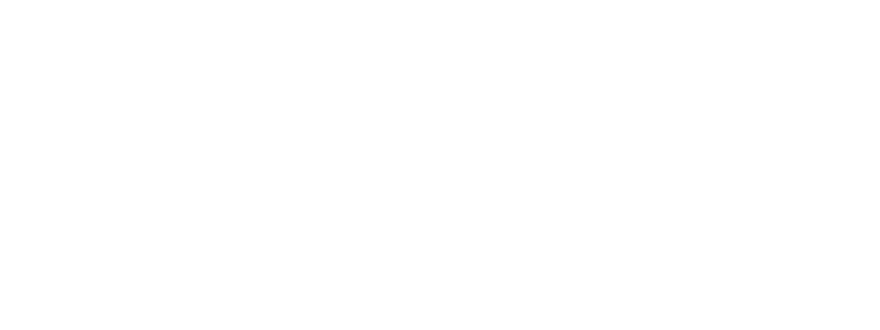

<IPython.core.display.Javascript object>


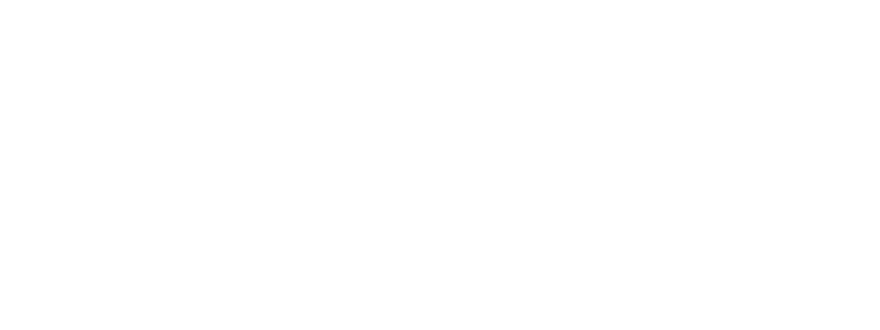

<IPython.core.display.Javascript object>


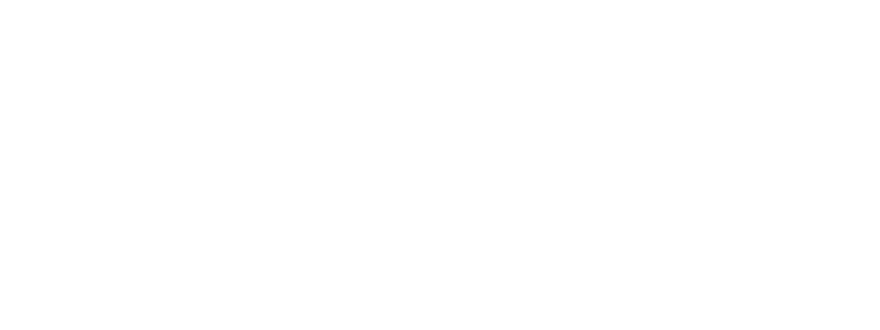

<IPython.core.display.Javascript object>


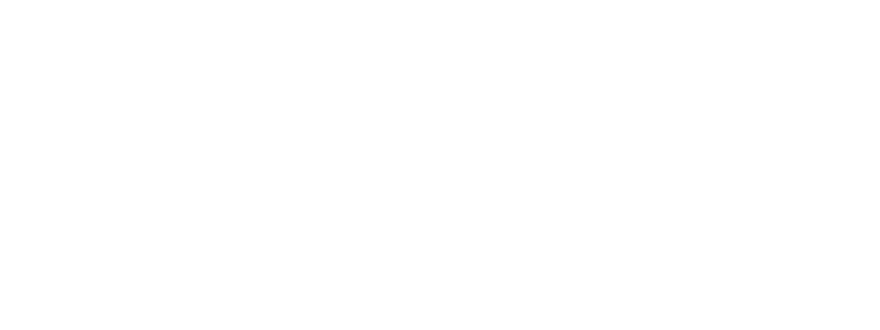

<IPython.core.display.Javascript object>


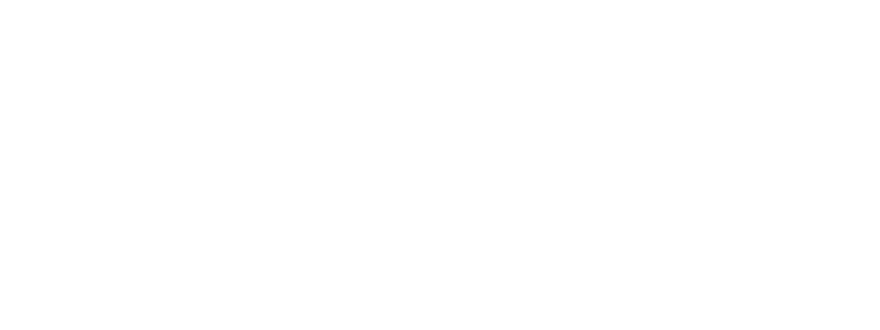

<IPython.core.display.Javascript object>


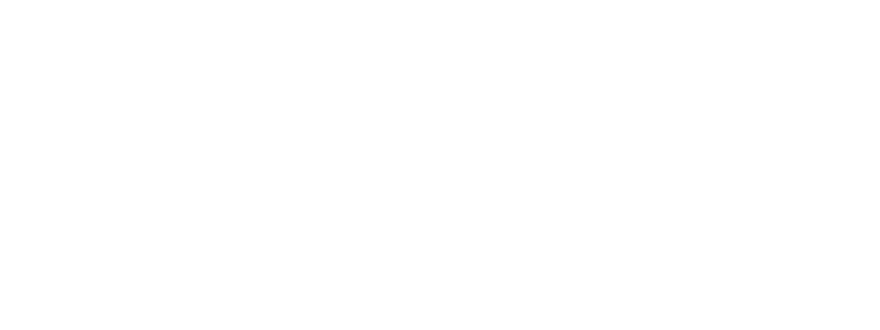

<IPython.core.display.Javascript object>


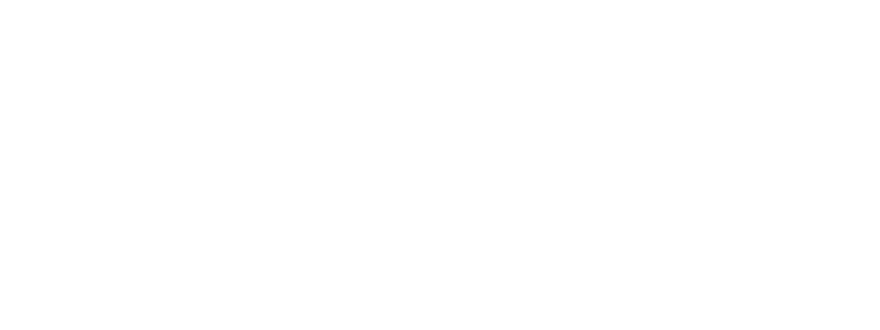

<IPython.core.display.Javascript object>


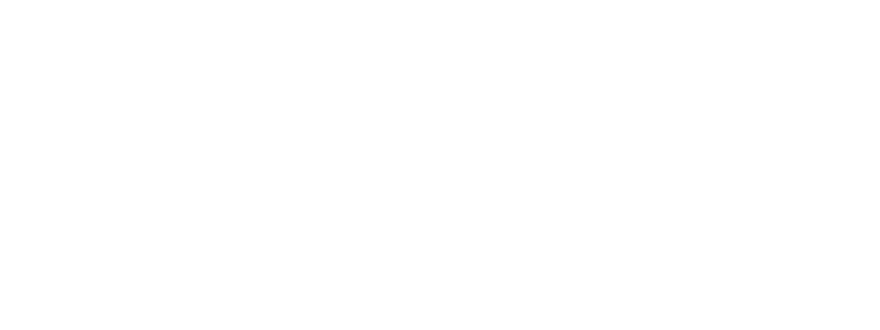

<IPython.core.display.Javascript object>


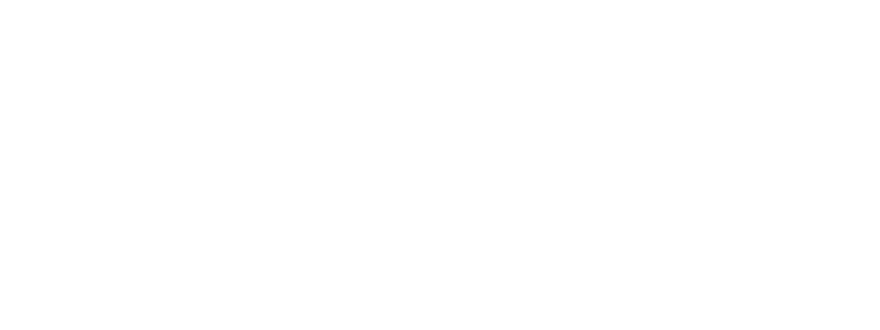

<IPython.core.display.Javascript object>


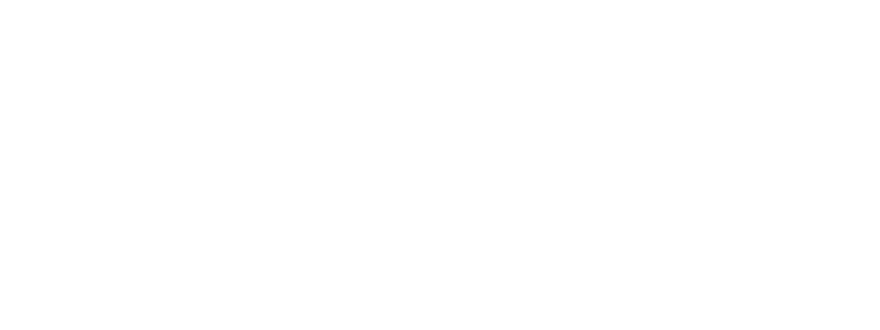

<IPython.core.display.Javascript object>


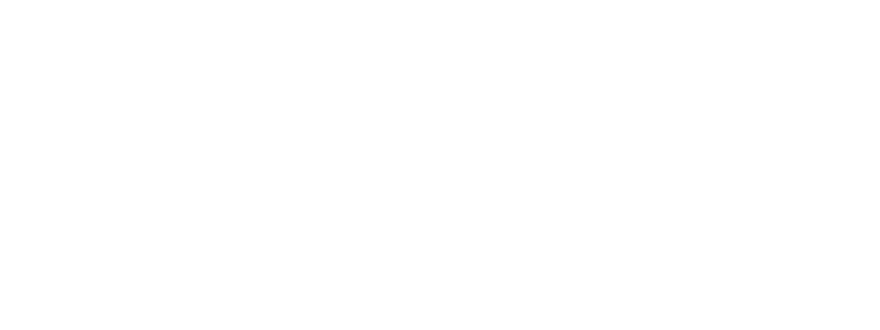

<IPython.core.display.Javascript object>


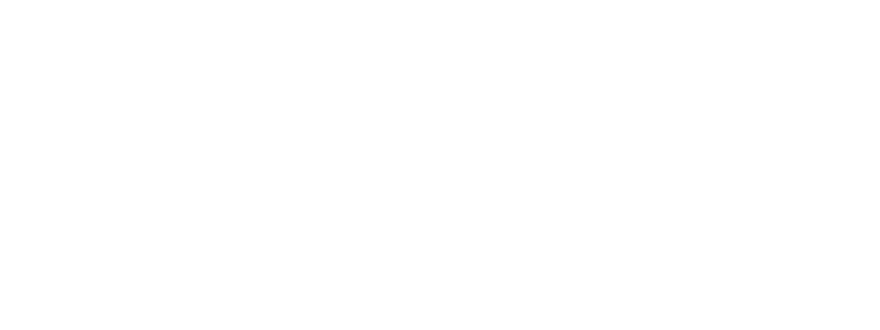

<IPython.core.display.Javascript object>


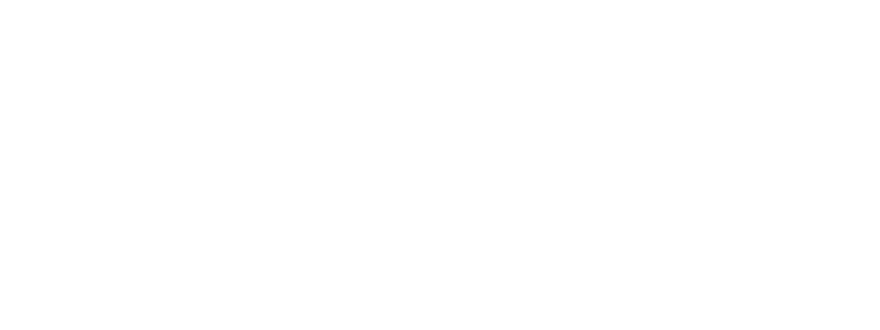

<IPython.core.display.Javascript object>


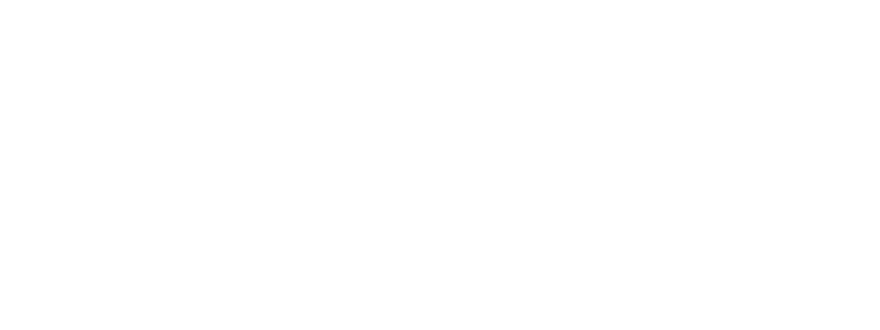

<IPython.core.display.Javascript object>


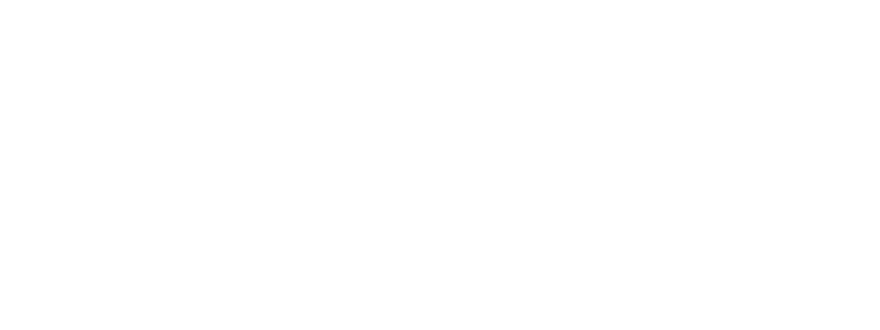

<IPython.core.display.Javascript object>


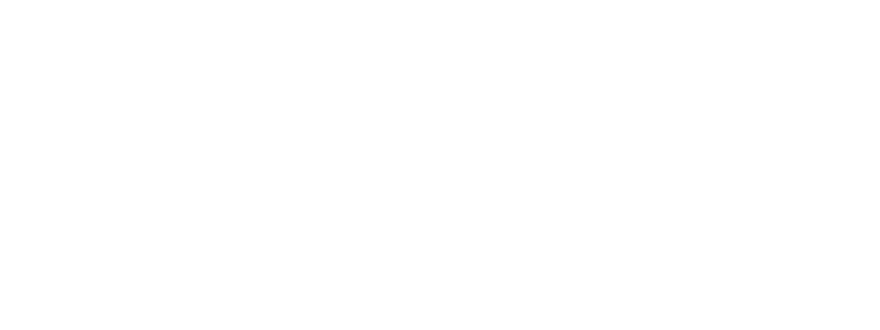

<IPython.core.display.Javascript object>


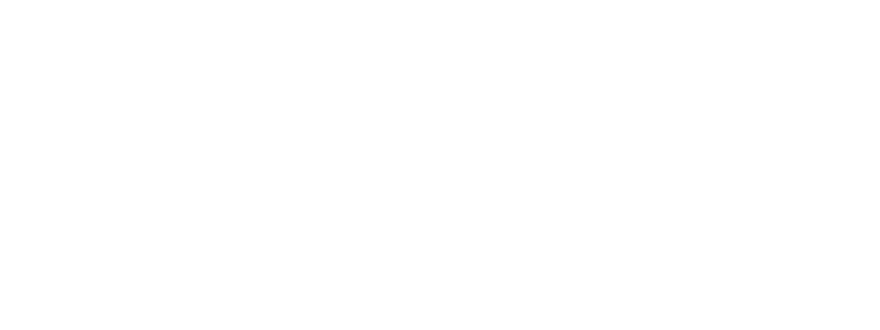

<IPython.core.display.Javascript object>


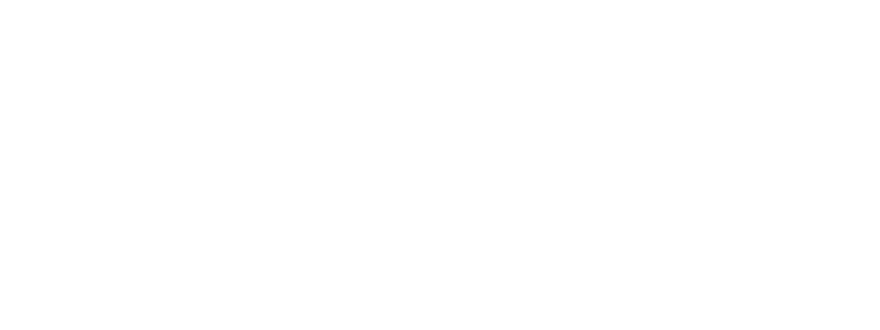

<IPython.core.display.Javascript object>


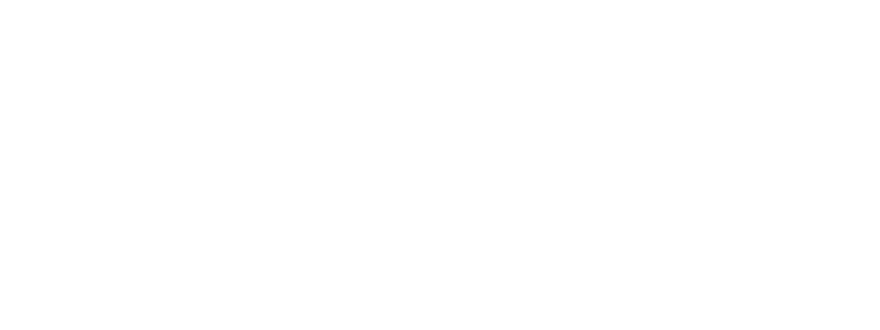

<IPython.core.display.Javascript object>


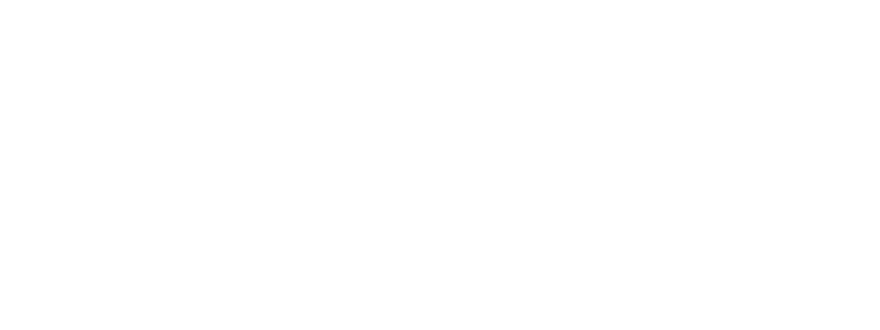

<IPython.core.display.Javascript object>


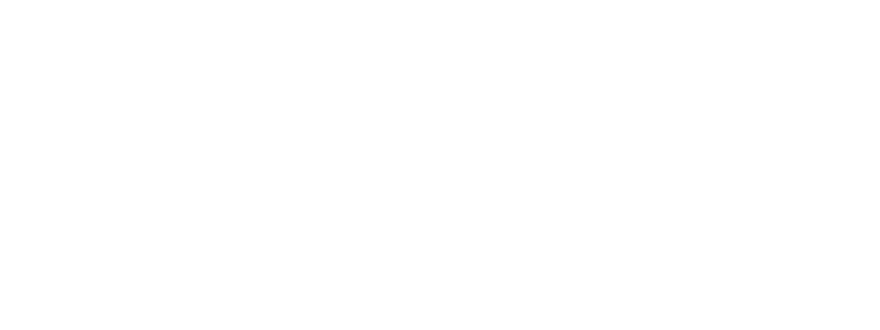

<IPython.core.display.Javascript object>


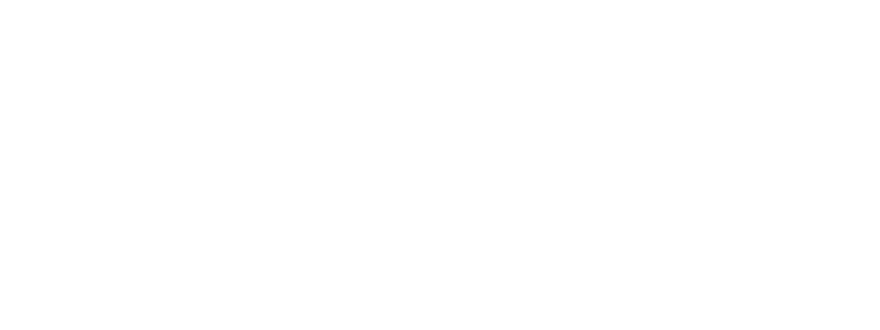

<IPython.core.display.Javascript object>


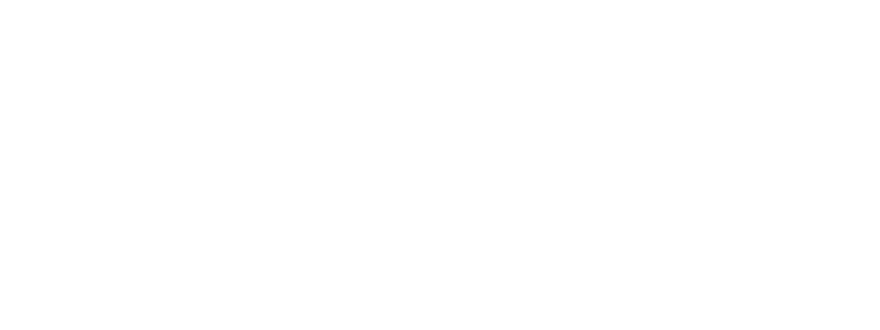

<IPython.core.display.Javascript object>


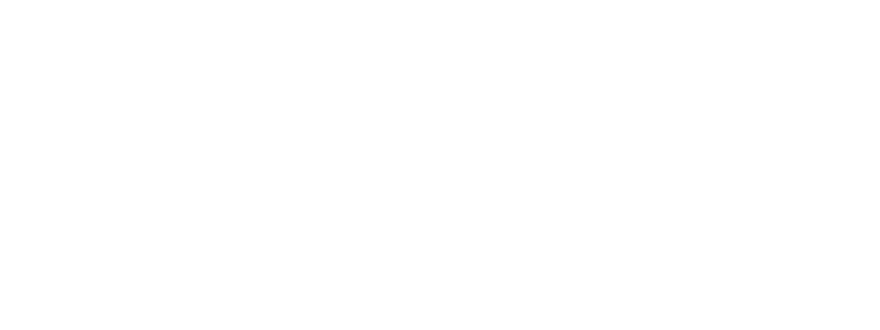

<IPython.core.display.Javascript object>


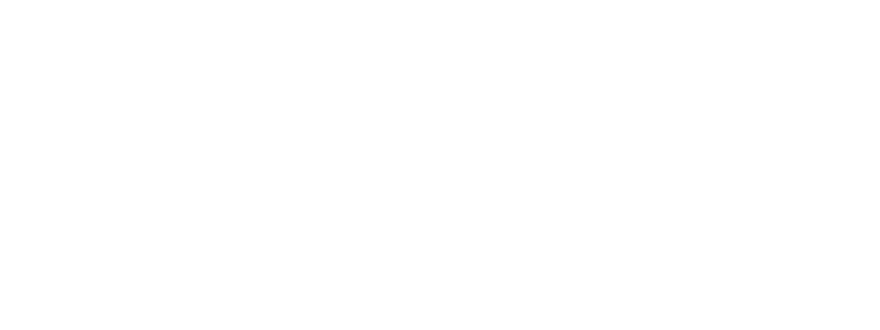

<IPython.core.display.Javascript object>


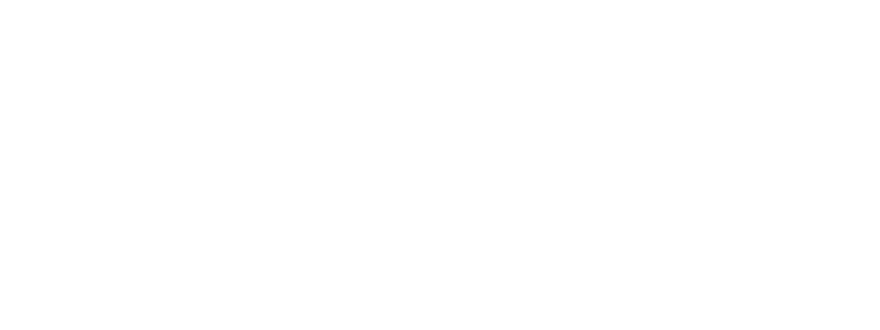

<IPython.core.display.Javascript object>


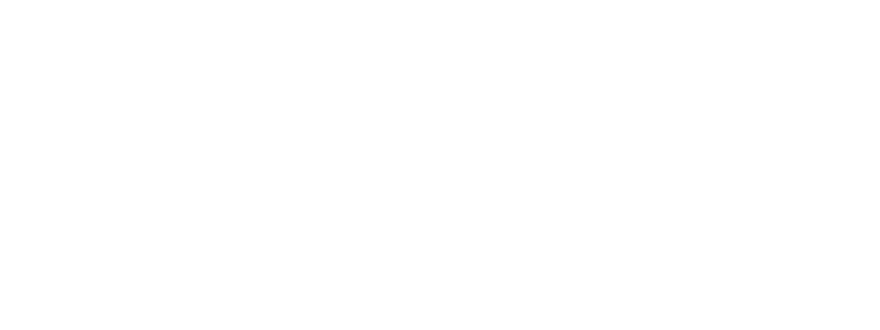

<IPython.core.display.Javascript object>


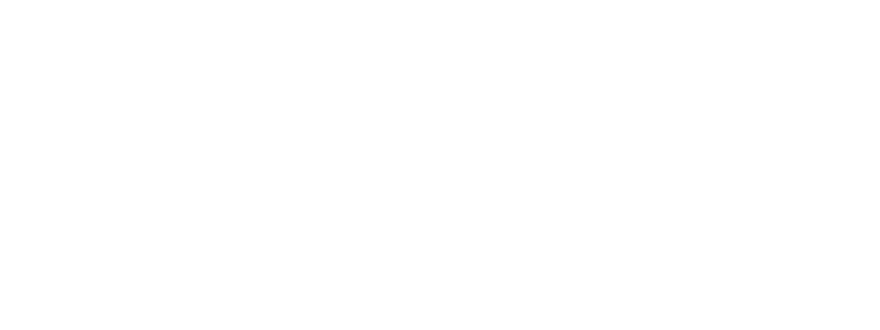

<IPython.core.display.Javascript object>


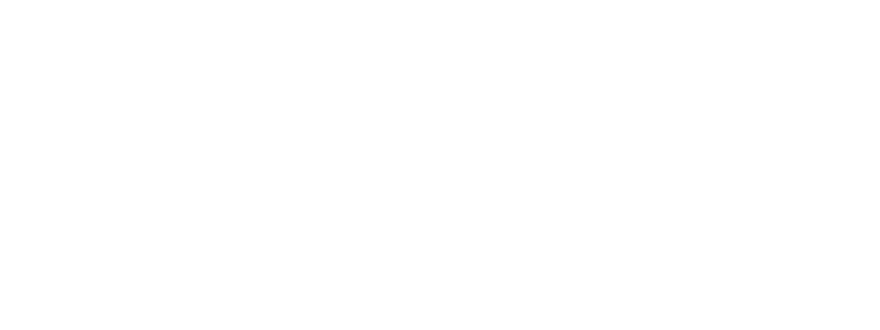

<IPython.core.display.Javascript object>


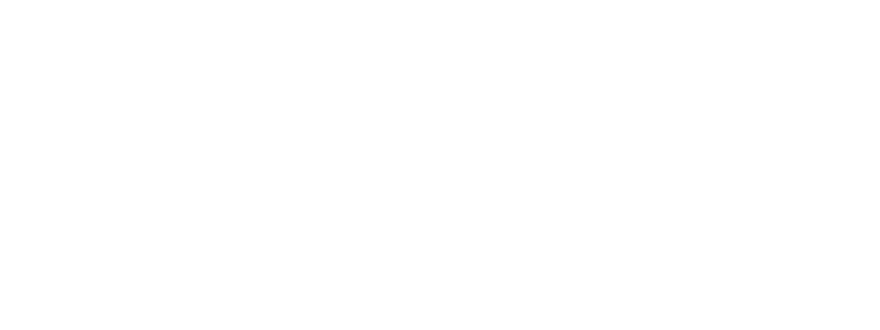

<IPython.core.display.Javascript object>


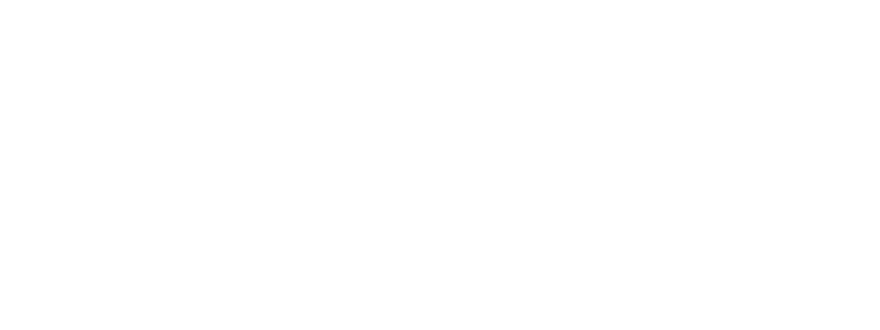

<IPython.core.display.Javascript object>


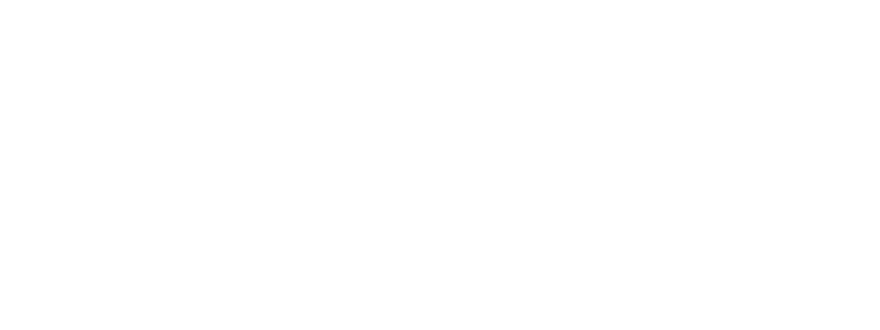

<IPython.core.display.Javascript object>


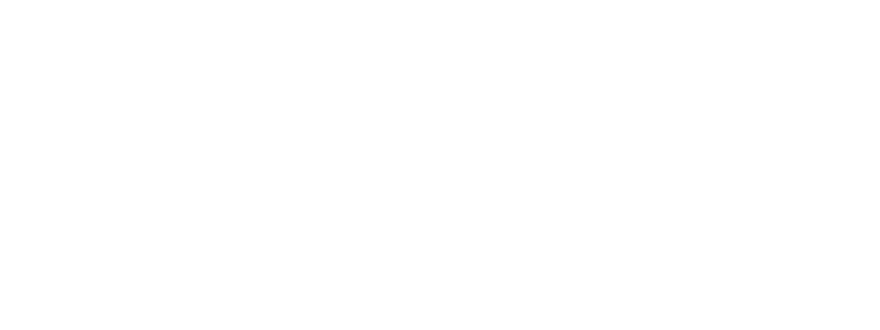

<IPython.core.display.Javascript object>


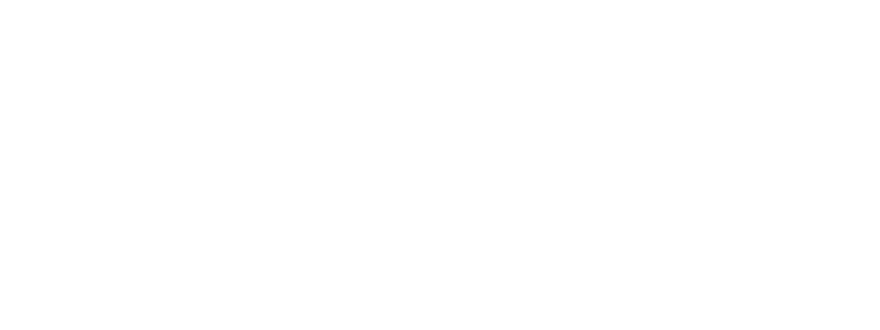

<IPython.core.display.Javascript object>


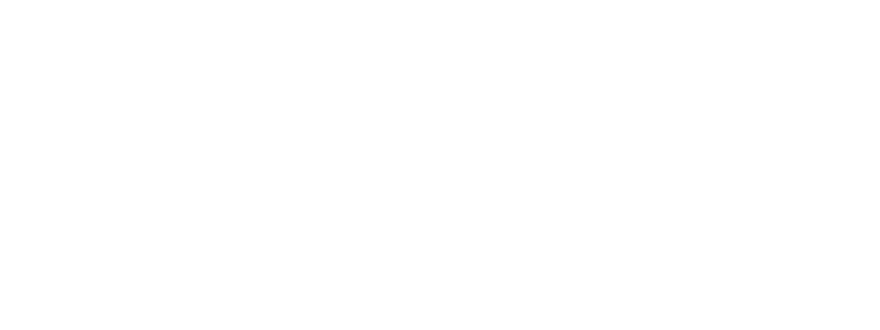

<IPython.core.display.Javascript object>


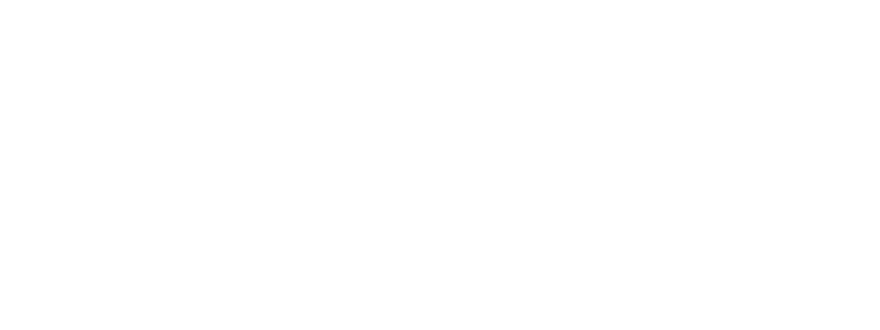

<IPython.core.display.Javascript object>


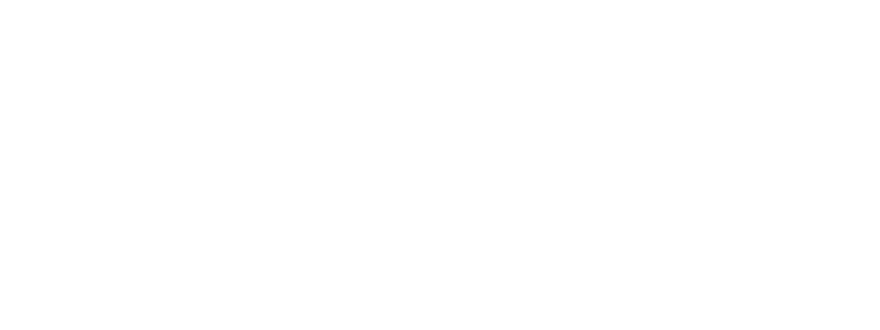

<IPython.core.display.Javascript object>


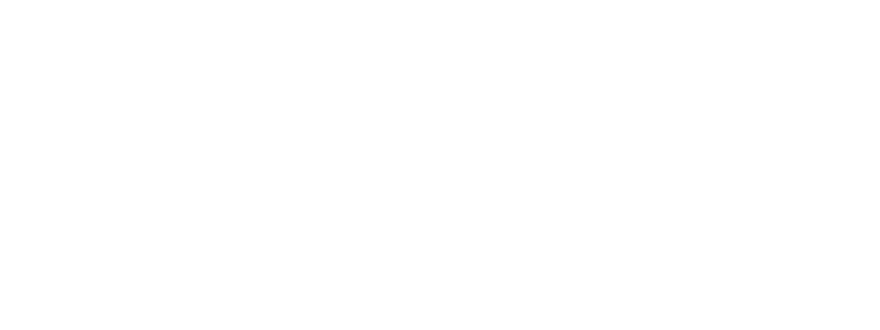

<IPython.core.display.Javascript object>


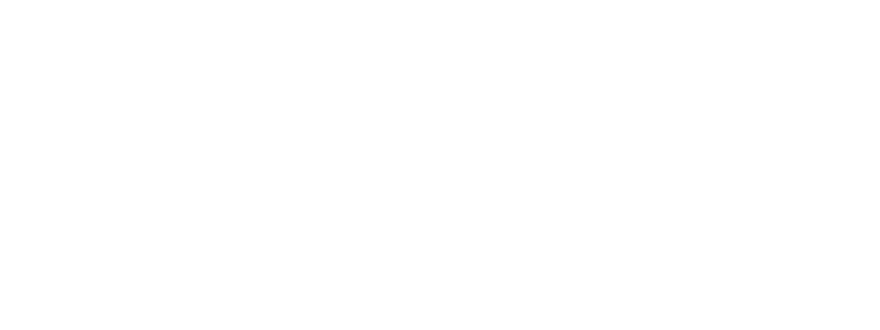

<IPython.core.display.Javascript object>


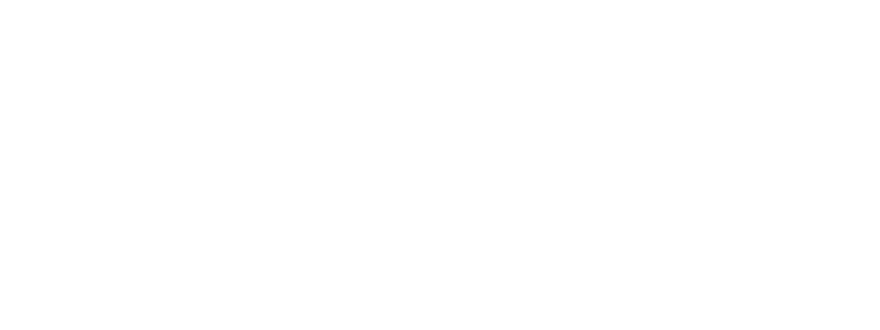

<IPython.core.display.Javascript object>


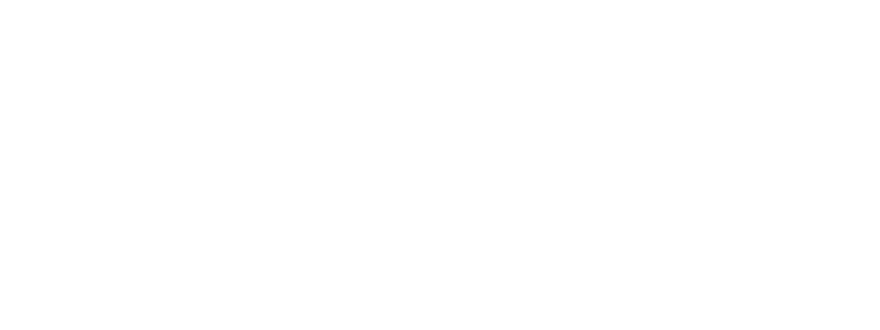

<IPython.core.display.Javascript object>


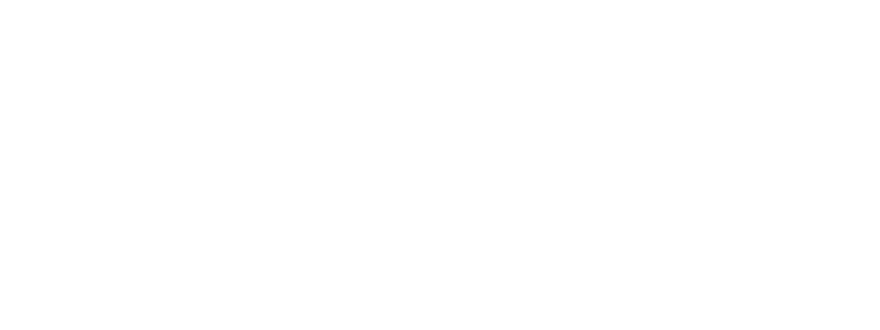

<IPython.core.display.Javascript object>


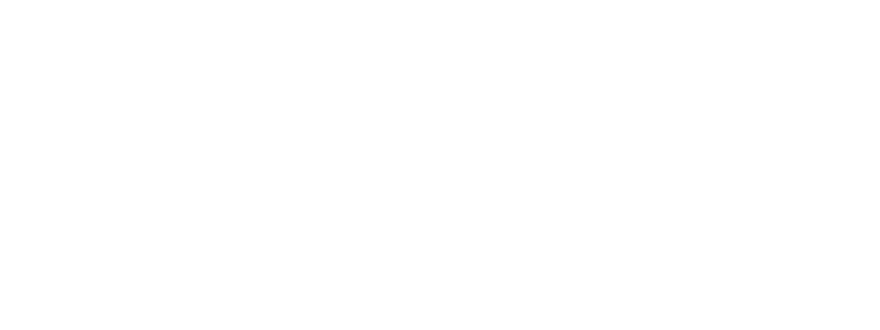

<IPython.core.display.Javascript object>


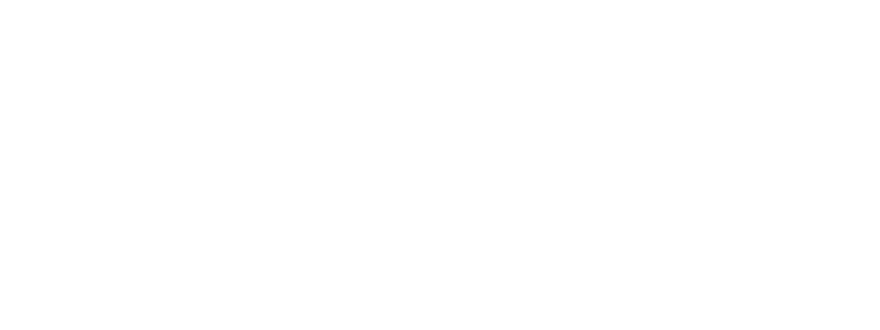

<IPython.core.display.Javascript object>


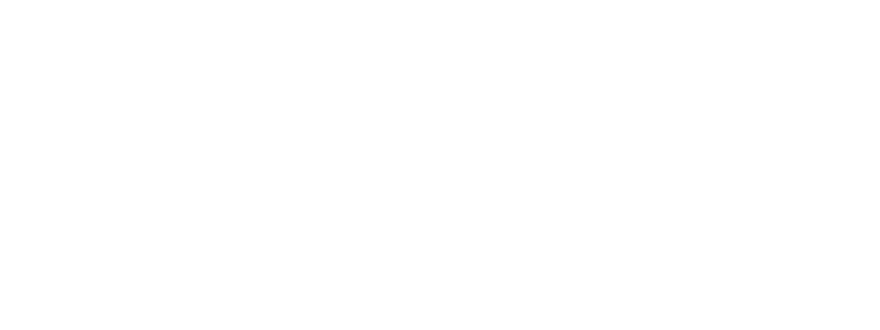

<IPython.core.display.Javascript object>


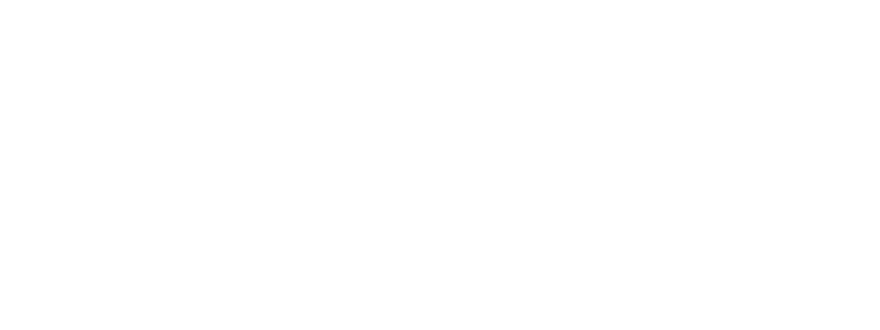

<IPython.core.display.Javascript object>


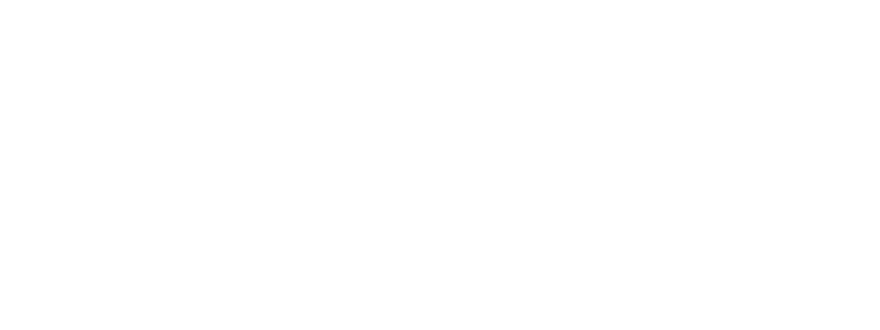

<IPython.core.display.Javascript object>


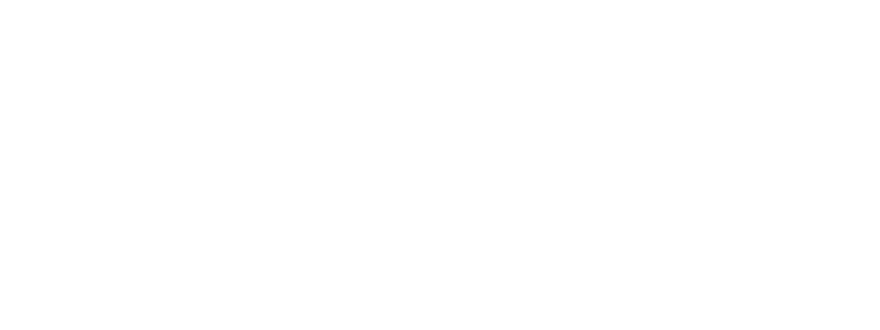

<IPython.core.display.Javascript object>


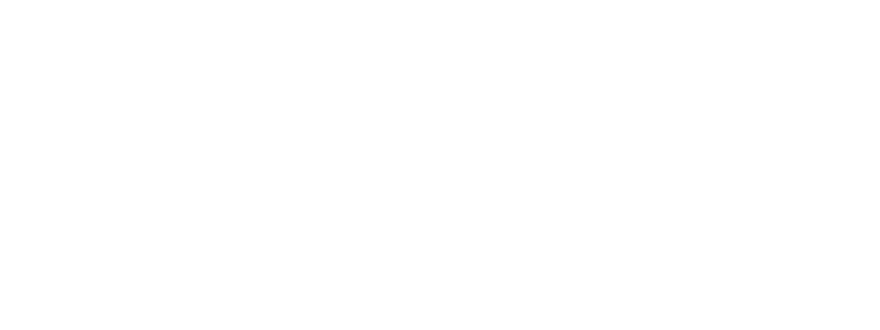

<IPython.core.display.Javascript object>


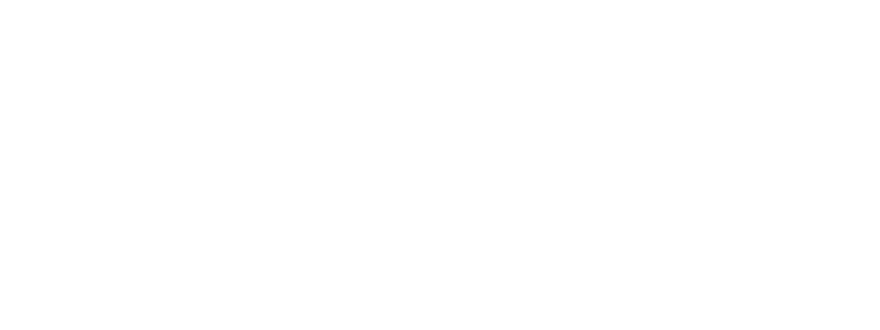

<IPython.core.display.Javascript object>


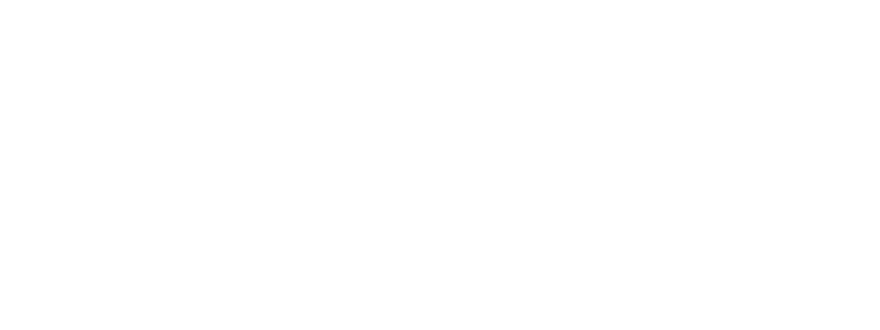

<IPython.core.display.Javascript object>


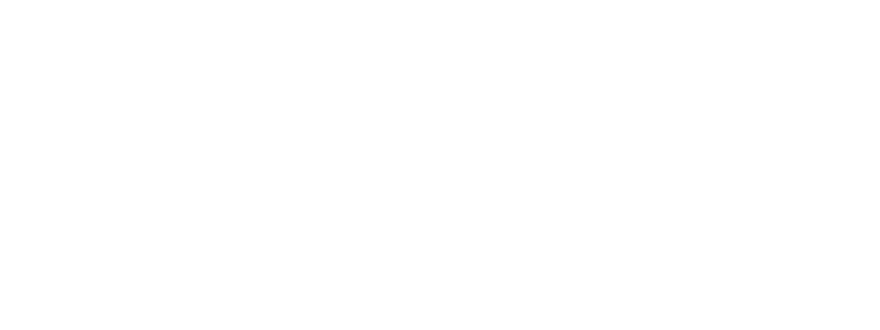

<IPython.core.display.Javascript object>


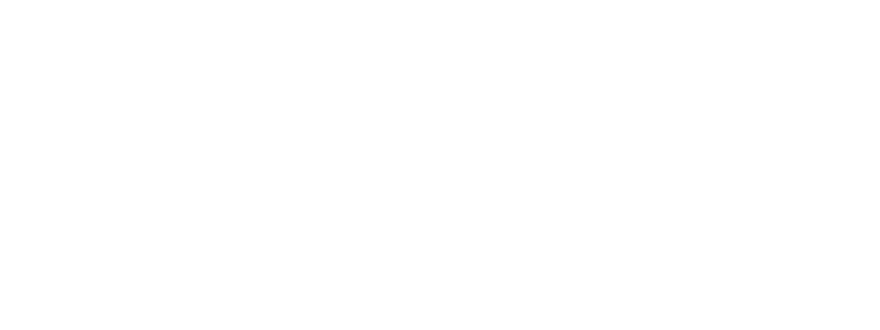

<IPython.core.display.Javascript object>


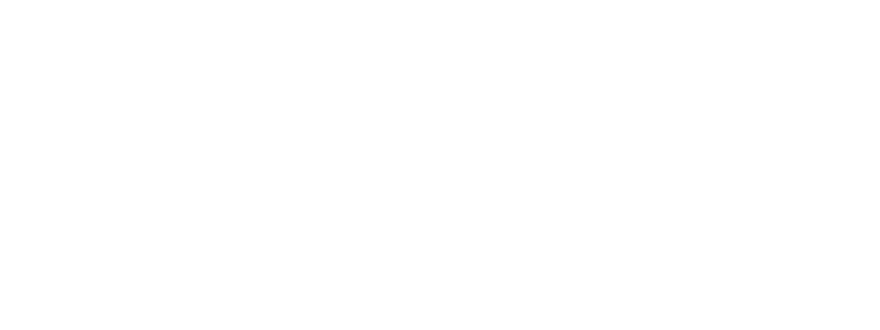

<IPython.core.display.Javascript object>


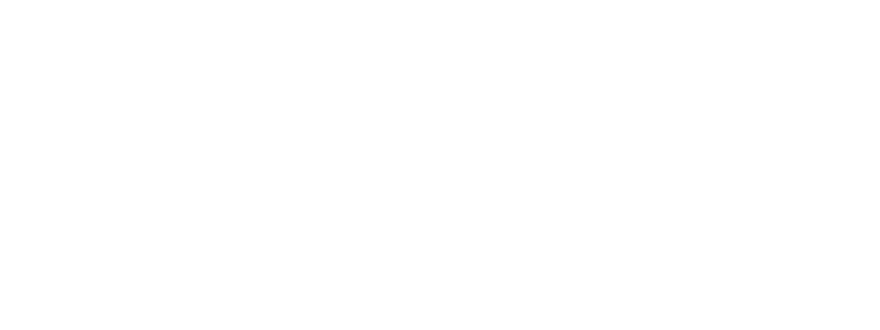

<IPython.core.display.Javascript object>


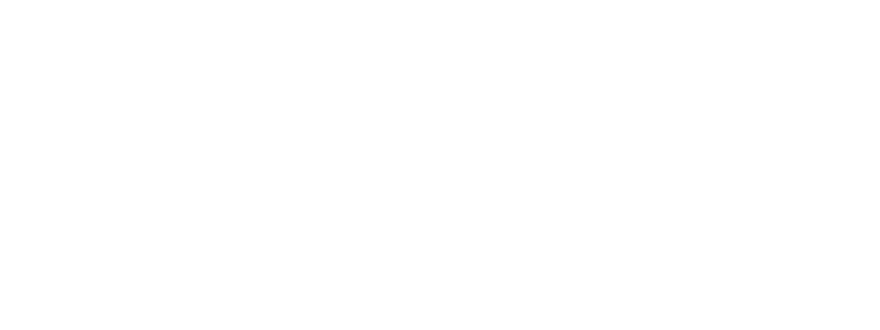

<IPython.core.display.Javascript object>


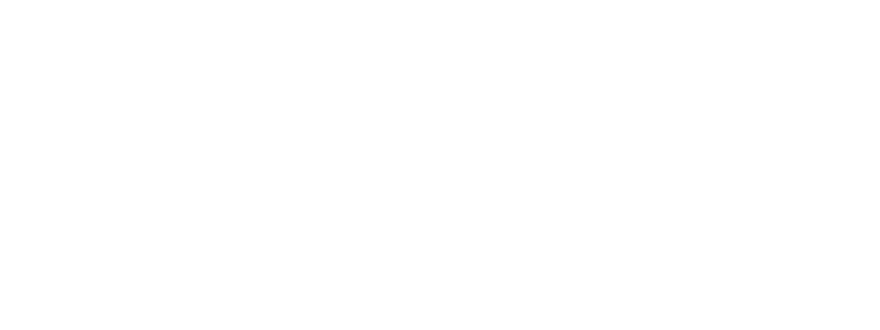

<IPython.core.display.Javascript object>


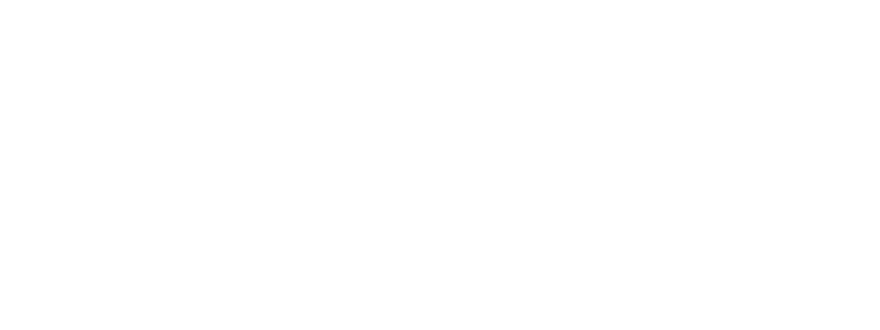

<IPython.core.display.Javascript object>


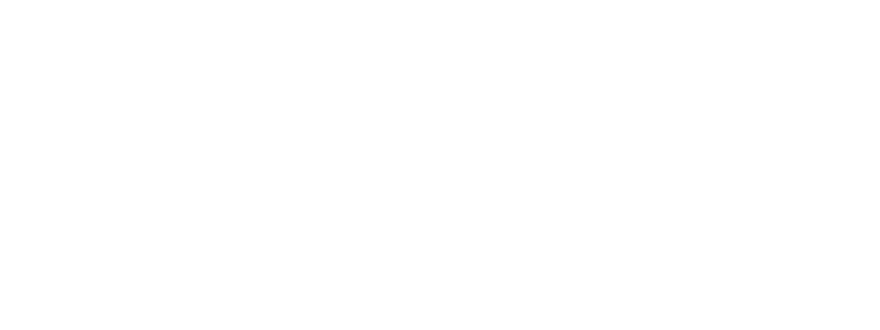

<IPython.core.display.Javascript object>


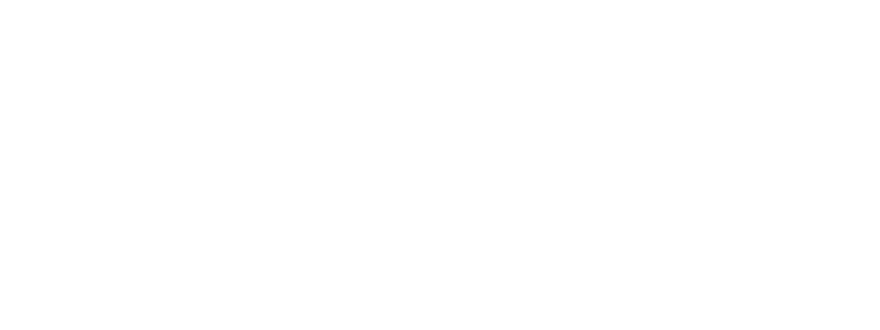

In [227]:
tmplist=[]

for roi in roi_list:
    rdf = gdf.get_group(roi)[['config', 'trial', response_type]]

    # Get mean response across trials for each config
    responses_df = pd.concat([pd.Series(g[response_type], name=c).reset_index(drop=True)\
                              for c, g in rdf.groupby(['config'])], axis=1)

    constant_params = ['aspect', 'luminance', 'position', 'stimtype', 'direction', 'xpos', 'ypos']
    paramnames = ['size', 'speed', 'sf']
    stimdf = sdf[paramnames]
    n_params = len(paramnames)

    bootdf = pd.concat([responses_df.sample(n_resamples, replace=True).mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)

    # Get all combinations of non-orientation configs
    paramconfigs = list(itertools.product(*[sdf[p].unique() for p in paramnames]))

    boot ={}
    true = {}
    all_responses=[]
    for paramvals in paramconfigs:
        if n_params == 3:
            currcfgs = sdf[( (sdf[paramnames[0]]==paramvals[0]) \
                              & (sdf[paramnames[1]]==paramvals[1]) \
                              & (sdf[paramnames[2]]==paramvals[2]) )].index.tolist()
            measured = presponses[( (presponses[paramnames[0]]==paramvals[0]) \
                      & (presponses[paramnames[1]]==paramvals[1]) \
                      & (presponses[paramnames[2]]==paramvals[2]) \
                      & (presponses['cell']==roi))]
        elif len(currcfgs)==0:
            continue
        bootvals = bootdf.loc[currcfgs].mean(axis=0)
        true_val = float(measured['response'].values)

        boot[paramvals] = bootvals
        true[paramvals] = true_val

        currvs = dict((pname, pval) for pname, pval in zip(paramnames, paramvals))
        currvs['response'] = true_val
        all_responses.append(pd.Series(currvs))

    alpha=95
    pvals=[]
    fig, axes = pl.subplots(2, 4, figsize=(8, 3))
    for ax, paramkey in zip(axes.flat, boot.keys()):
        ax.hist(boot[paramkey], color='k', alpha=0.3)
        ordered = sorted(boot[paramkey])
        ci_lower = np.percentile(ordered, (100-alpha)/2)
        ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))

        ax.axvline(x=ci_lower, color='k', linestyle=':')
        ax.axvline(x=ci_upper, color='k', linestyle=':')
        ax.axvline(x=true[paramkey], color='r')
        ax.set_title(paramkey)
        nonsig = ci_lower <= true[paramkey] <= ci_upper
        pvals.append(not nonsig)
    pl.subplots_adjust(wspace=0.5, hspace=0.8)
    pl.savefig(os.path.join(roi_fitdir, 'roi%05d.png' % int(roi+1)))
    pl.close()

    if not any(pvals):
        print("roi %i: no sig" % int(roi))
        continue

    sigdf =  pd.concat(all_responses, axis=1).T
    sigdf['cell'] = [roi for _ in range(sigdf.shape[0])]
    tmplist.append(sigdf)

In [228]:
respdf = pd.concat(tmplist, axis=0)


In [229]:
respdf.shape

(1016, 5)

In [233]:
np.where(presponses != respdf)

(array([], dtype=int64), array([], dtype=int64))

<IPython.core.display.Javascript object>


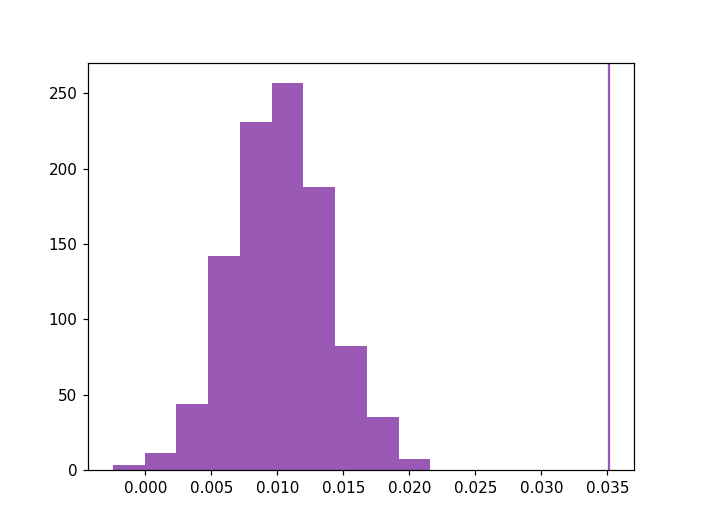

In [177]:
pl.figure()
pl.hist(bootdf.loc[currcfgs].mean())

pl.axvline(x=float(measured['response'].values))

In [175]:
measured['response'].values[0]

0.035099959146769763

In [145]:
currvs = dict((pname, pval) for pname, pval in zip(paramnames, paramvals))
currvs

{'sf': 0.5, 'size': 20, 'speed': 20}

In [151]:
presponses[(presponses['size'] )]

response   sf   size  speed  cell
0 -0.035847  0.1  200.0   10.0     0
1 -0.003289  0.5  200.0   10.0     0
2 -0.036890  0.1  200.0   20.0     0
3 -0.004927  0.5  200.0   20.0     0
4 -0.062465  0.1   20.0   10.0     0

In [154]:
presponses

response   sf   size  speed  cell
0  -0.035847  0.1  200.0   10.0     0
1  -0.003289  0.5  200.0   10.0     0
2  -0.036890  0.1  200.0   20.0     0
3  -0.004927  0.5  200.0   20.0     0
4  -0.062465  0.1   20.0   10.0     0
5  -0.023710  0.5   20.0   10.0     0
6  -0.074471  0.1   20.0   20.0     0
7  -0.015406  0.5   20.0   20.0     0
0   0.043070  0.1  200.0   10.0     5
1   0.057846  0.5  200.0   10.0     5
2   0.011296  0.1  200.0   20.0     5
3   0.047242  0.5  200.0   20.0     5
4   0.005679  0.1   20.0   10.0     5
5   0.024053  0.5   20.0   10.0     5
6   0.029231  0.1   20.0   20.0     5
7   0.096032  0.5   20.0   20.0     5
0   0.028274  0.1  200.0   10.0     9
1   0.017690  0.5  200.0   10.0     9
2   0.046708  0.1  200.0   20.0     9
3   0.010348  0.5  200.0   20.0     9
4   0.119779  0.1   20.0   10.0     9
5   0.049180  0.5   20.0   10.0     9
6   0.058033  0.1   20.0   20.0     9
7   0.027126  0.5   20.0   20.0     9
0   0.035532  0.1  200.0   10.0    10
1   0.014397  0.5  200.0   10.0    10
2   0.032001  0.1  200.0   20.0    10
3   0.008932  0.5  200.0   20.0    10
4   0.074831  0.1   20.0   10.0    10
5   0.046434  0.5   20.0   10.0    10
..       ...  ...    ...    ...   ...
2   0.055152  0.1  200.0   20.0   249
3   0.022631  0.5  200.0   20.0   249
4   0.069666  0.1   20.0   10.0   249
5   0.050875  0.5   20.0   10.0   249
6   0.063761  0.1   20.0   20.0   249
7   0.063420  0.5   20.0   20.0   249
0   0.034414  0.1  200.0   10.0   252
1  -0.000219  0.5  200.0   10.0   252
2   0.048034  0.1  200.0   20.0   252
3   0.003819  0.5  200.0   20.0   252
4   0.050472  0.1   20.0   10.0   252
5   0.035369  0.5   20.0   10.0   252
6   0.007835  0.1   20.0   20.0   252
7   0.023977  0.5   20.0   20.0   252
0   0.180911  0.1  200.0   10.0   255
1  -0.003709  0.5  200.0   10.0   255
2   0.127644  0.1  200.0   20.0   255
3   0.034778  0.5  200.0   20.0   255
4   0.201743  0.1   20.0   10.0   255
5   0.162512  0.5   20.0   10.0   255
6   0.133250  0.1   20.0   20.0   255
7   0.169776  0.5   20.0   20.0   255
0   0.132266  0.1  200.0   10.0   258
1   0.040012  0.5  200.0   10.0   258
2   0.097594  0.1  200.0   20.0   258
3   0.033791  0.5  200.0   20.0   258
4   0.135695  0.1   20.0   10.0   258
5   0.073916  0.5   20.0   10.0   258
6   0.108671  0.1   20.0   20.0   258
7   0.063532  0.5   20.0   20.0   258

[1016 rows x 5 columns]

In [165]:
measured = presponses[( (presponses[paramnames[0]]==paramvals[0]) \
          & (presponses[paramnames[1]]==paramvals[1]) \
          & (presponses[paramnames[2]]==paramvals[2]) \
          & (presponses['cell']==roi))]


In [ ]:
pl.figure();


In [111]:

n_params = len(paramnames)        
tmplist = []
for roi in roi_list:
    rdf = gdf.get_group(roi)[['config', 'trial', response_type]]

    # Get mean response across trials for each config
    responses_df = pd.concat([pd.Series(g[response_type], name=c).reset_index(drop=True)\
                              for c, g in rdf.groupby(['config'])], axis=1)

    # Get all combinations of non-orientation configs
    paramconfigs = list(itertools.product(*[sdf[p].unique() for p in paramnames]))

    allresponses = []
    for paramvals in paramconfigs:
        if n_params == 3:
            currcfgs = sdf[( (sdf[paramnames[0]]==paramvals[0]) \
                              & (sdf[paramnames[1]]==paramvals[1]) \
                              & (sdf[paramnames[2]]==paramvals[2]) )].index.tolist()
        elif n_params == 2:
            currcfgs = sdf[( (sdf[paramnames[0]]==paramvals[0]) \
                              & (sdf[paramnames[1]]==paramvals[1]) )].index.tolist()

        if len(currcfgs)==0:
            continue
        meanr = bootdf.loc[currcfgs].mean()
        currvs = dict((pname, pval) for pname, pval in zip(paramnames, paramvals))
        currvs['response'] = meanr
        allresponses.append(pd.Series(currvs))
    respdf = pd.concat(allresponses, axis=1).T
    respdf['cell'] = [roi for _ in range(respdf.shape[0])]
    tmplist.append(respdf)
nonori_responses = pd.concat(tmplist, axis=0)

NameError: name 'paramnames' is not defined